In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from utils import *
from model import get_model

from sklearn.metrics import roc_auc_score, confusion_matrix
from torchvision.ops import sigmoid_focal_loss
from torch.nn.functional import binary_cross_entropy_with_logits

/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# ====== 실험 설정 ====== # 중요함
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 사용할 데이터 종류 설정, 단일 학습인지 멀티테스크인지 설정 (URP 에서 AAFOS FALSE 설정)
ASOS = True
AAFOS = False
assert ASOS or AAFOS, "At least one of ASOS or AAFOS must be True."

channels = '16ch' # '16ch' or 'ae304', 16ch일때 [16,512,512]
time_range = [-12]
resolution = '2km' # '1km':1024 or '2km':512
postfix = 'baseline_prediction_384'

output_path = "results/"
output_path += 'asos_' if ASOS else ''
output_path += 'aafos_' if AAFOS else ''
output_path += channels + '_'
output_path += 'time' + str(time_range) + '_'
output_path += resolution
output_path += ('_' + postfix) if postfix != '' else postfix
print(f"Output path name: {output_path}")

# 기본 asos:aafos 비율 5:1
asos_aafos_ratio = 5.0
asos_weight = asos_aafos_ratio / (asos_aafos_ratio + 1.0 * AAFOS) if ASOS else 0.0
aafos_weight = 1.0 / (asos_aafos_ratio * ASOS + 1.0) if AAFOS else 0.0
print(f"ASOS weight: {asos_weight:.2f}, AAFOS weight: {aafos_weight:.2f}")

# 기타 ablation 설정
latlon = False

# 실험중인 설정들
central_patch = False
use_patch = False

#  ====== 채널 설정 ====== #
if channels == '16ch':
    channels_name = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133'] # 시각화 용
    channels_calib = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133']
    
    channels_mean = [1.1912e-01, 1.1464e-01, 1.0734e-01, 1.2504e-01, 5.4983e-02, 9.0381e-02,
                2.7813e+02, 2.3720e+02, 2.4464e+02, 2.5130e+02, 2.6948e+02, 2.4890e+02,
                2.7121e+02, 2.7071e+02, 2.6886e+02, 2.5737e+02]
    channels_std  = [0.1306,  0.1303,  0.1306,  0.1501,  0.0268,  0.0838, 15.8211,  6.1468,
                7.8054,  9.3251, 16.4265,  9.6150, 17.2518, 17.6064, 17.0090, 12.5026]

else:
    raise ValueError("Invalid channels.")


train_data_info_list = []
train_data_info_list.append({
    'label_type': 'asos', # 'asos' or 'aafos'
    'start_date_str': '20200101', #  라벨기준 일자. KST
    'end_date_str': '20230630',
    'hour_col_pairs': [(6,'AM')],
    'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
}) if ASOS else None

test_asos_data_info_list = [
    {
        'label_type': 'asos', # 'asos' or 'aafos'
        'start_date_str': '20230701', #  라벨기준 일자. KST
        'end_date_str': '20240630',
        'hour_col_pairs': [(6,'AM')],
        'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
    },
] if ASOS else None


origin_size = 900 if resolution == '2km' else 1800
image_size = 384  # 384x384 크기로 변경
patch_size = 384  # 패치 크기도 384로 변경

data_path = '/home/dm4/repo/data/kma_data/date_kst_URP_384/'

misc_channels = {
    'elevation':'elevation_1km_3600.npy',
    'vegetation':'vegetation_1km_3600.npy',
    'watermap':'watermap_1km_avg_3600.npy'
}
lat_lon_path = 'assets/gk2a_ami_ko010lc_latlon.nc'

# 학습과 관련된 설정! 변경 시 주의 요함
batch_size = 64
num_workers = 8

epochs = 25
lr = 1e-3
decay = [10, 20]
lr_decay = 0.1
weight_decay = 1e-5
threshold = [0.25]

# 자동으로 설정되는 값
asos_x_base, asos_y_base, asos_image_size = get_crop_base(image_size, label_type='asos')
aafos_x_base, aafos_y_base, aafos_image_size = get_crop_base(image_size, label_type='aafos')
aafos_x_base -= asos_x_base
aafos_y_base -= asos_y_base

total_channels = len(channels_name) * len(time_range) + len(misc_channels.keys())
total_channels += 2 if latlon else 0
print(total_channels)

Output path name: results/asos_16ch_time[-12]_2km_baseline_prediction_384
ASOS weight: 1.00, AAFOS weight: 0.00
19


In [3]:
asos_image_size

384

dict_keys([93, 108, 112, 119, 131, 133, 136, 143, 146, 156, 177, 102, 104, 115, 138, 152, 155, 159, 165, 168, 169, 184, 189])


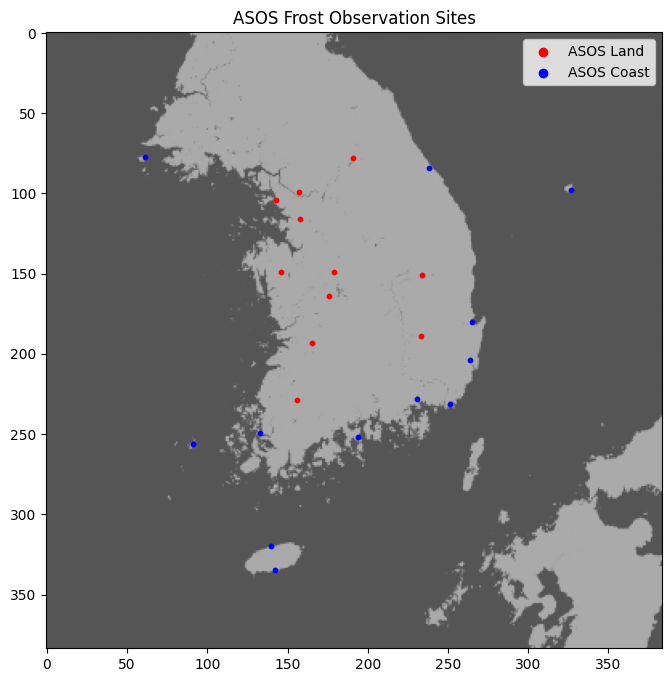

In [4]:
asos_land_map = {k: coord_to_map(*v, origin_size) for k, v in ASOS_LAND_COORD.items()}
asos_land_map = {k: (v[0]-asos_x_base, v[1]-asos_y_base) for k, v in asos_land_map.items()}
asos_coast_map = {k: coord_to_map(*v, origin_size) for k, v in ASOS_COAST_COORD.items()}
asos_coast_map = {k: (v[0]-asos_x_base, v[1]-asos_y_base) for k, v in asos_coast_map.items()}
asos_map_dict = {**asos_land_map, **asos_coast_map}
print(asos_map_dict.keys())

CROP_BASE = 64
image = np.load('assets/misc_channels/watermap_1km_avg_3600.npy', allow_pickle=True)
image = -image + 1.0
image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_CUBIC)
image = image[CROP_BASE:CROP_BASE+asos_image_size, CROP_BASE:CROP_BASE+asos_image_size]  # 384x384로 crop


plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=-1, vmax=2)

for k, v in asos_land_map.items():
    plt.scatter(v[0], v[1], c='r', marker='o', s=10)
for k, v in asos_coast_map.items():
    plt.scatter(v[0], v[1], c='b', marker='o', s=10)

    
plt.scatter([], [], c='r', marker='o', label='ASOS Land')
plt.scatter([], [], c='b', marker='o', label='ASOS Coast')

    
plt.title('ASOS Frost Observation Sites')
plt.legend()
plt.show()

In [5]:
if channels_mean is None:
    date_list = os.listdir(data_path)
    date_list = [date for date in date_list if '20200101' <= date < '20240101']

    npy_list = []
    for date in tqdm(date_list[::10]):
        for file in os.listdir(os.path.join(data_path, date)):
            if channels not in file:
                continue
            npy = np.load(os.path.join(data_path, date, file), allow_pickle=True).astype(np.float32) # (C, H, W)
            npy_list.append(npy)
    npy_array = np.stack(npy_list, axis=0)
    print(npy_array.shape) # (N, C, H, W)

    channels_mean = npy_array.mean(axis=(0,2,3)).tolist()
    channels_std = npy_array.std(axis=(0,2,3)).tolist()

channels_mean = channels_mean * len(time_range)
channels_std = channels_std * len(time_range)

print(channels_mean)
print(channels_std)

[0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37]
[0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026]


In [6]:
lat_lon_data = nc.Dataset(lat_lon_path)
lat = lat_lon_data['lat'][:].data
lon = lat_lon_data['lon'][:].data

lat = cv2.resize(lat, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
lon = cv2.resize(lon, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
print(lat.shape, lon.shape)

asos_lat = lat[asos_y_base:asos_y_base+asos_image_size, asos_x_base:asos_x_base+asos_image_size]
asos_lon = lon[asos_y_base:asos_y_base+asos_image_size, asos_x_base:asos_x_base+asos_image_size]
print(asos_lat.shape, asos_lon.shape)


lcc = ccrs.LambertConformal(central_longitude=126, central_latitude=38, standard_parallels = (30,60))
proj = ccrs.PlateCarree()

(900, 900) (900, 900)
(384, 384) (384, 384)


MISC images shape: torch.Size([3, 384, 384])
Total mean: [0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 74.05298614501953, 0.149159774184227, 0.7218806743621826]
Total std: [0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 178.60623168945312, 0.2882087826728821, 0.4411412179470062]


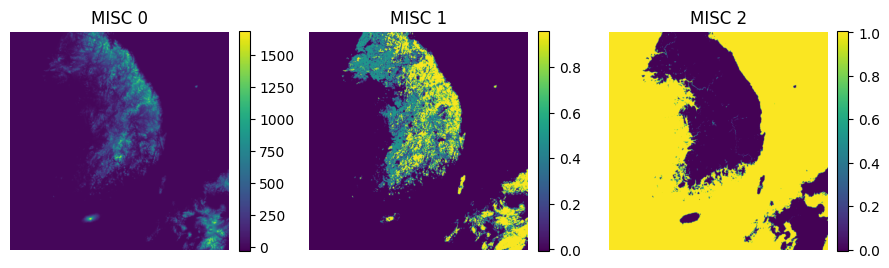

In [7]:
"""
MISC 0: Elevation (고도)
MISC 1: Water Bodies Index (수역 여부)
MISC 2: Vegetation Index (식생 여부)
"""
CROP_BASE = 64  # 512 → 384 crop offset

misc_images = []
for misc_channel, misc_path in misc_channels.items():
    misc_image = np.load(f'assets/misc_channels/{misc_path}', allow_pickle=True)
    # 3600 → 512로 resize 후, 64:448 crop하여 384x384 생성 (위성 이미지와 동일한 영역)
    misc_image = cv2.resize(misc_image, (512, 512), interpolation=cv2.INTER_CUBIC)
    misc_image = misc_image[CROP_BASE:CROP_BASE+image_size, CROP_BASE:CROP_BASE+image_size]
    misc_images.append(misc_image)
misc_images = np.stack(misc_images, axis=0)
misc_images = torch.tensor(misc_images, dtype=torch.float32)

if latlon:
    lat_image = cv2.resize(asos_lat, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    lon_image = cv2.resize(asos_lon, (asos_image_size, asos_image_size), interpolation=cv2.INTER_CUBIC)
    
    lat_image = torch.tensor(lat_image, dtype=torch.float32).unsqueeze(0)
    lon_image = torch.tensor(lon_image, dtype=torch.float32).unsqueeze(0)
    misc_images = torch.cat([misc_images, lat_image, lon_image], dim=0)

print(f'MISC images shape: {misc_images.shape}')

# normalize by channel
misc_mean = misc_images.mean(dim=[1,2], keepdim=True)
misc_std = misc_images.std(dim=[1,2], keepdim=True)

total_mean = channels_mean + misc_mean.squeeze().tolist()
total_std = channels_std + misc_std.squeeze().tolist()

print(f'Total mean: {total_mean}')
print(f'Total std: {total_std}')

fig, axs = plt.subplots(math.ceil(misc_images.shape[0]/3), 3, figsize=(9, 5))
for i in range(misc_images.shape[0]):
    ax = axs.flatten()[i]
    ax.imshow(misc_images[i].numpy(), cmap='viridis')
    ax.set_title(f'MISC {i}')
    colorbar = plt.colorbar(mappable=ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
for i in range(misc_images.shape[0], len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.axis('off')
plt.tight_layout()
plt.show()

ASOS patch candidates: [[0 0]]


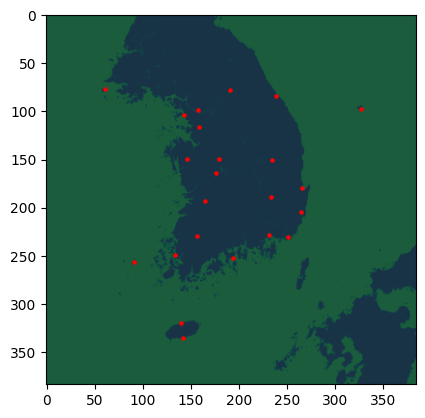

In [8]:
asos_patch_candidate = np.zeros([image_size, image_size], dtype=np.uint8)
for x, y in asos_map_dict.values():
    y_min = np.clip(y - 3*patch_size//4, 0, image_size - patch_size+1)
    y_max = np.clip(y - patch_size//4, 0, image_size - patch_size+1)   
    x_min = np.clip(x - 3*patch_size//4, 0, image_size - patch_size+1)
    x_max = np.clip(x - patch_size//4, 0, image_size - patch_size+1)
    asos_patch_candidate[y_min:y_max, x_min:x_max] = 1
    plt.scatter(x, y, c='r', marker='o', s=5)
plt.imshow(misc_images[2], cmap='viridis', vmin=-1, vmax=2)
plt.imshow(asos_patch_candidate, cmap='gray', vmin=0, vmax=1, alpha=0.5)
asos_patch_candidate = np.argwhere(asos_patch_candidate == 1)[:, [1, 0]]
print(f'ASOS patch candidates: {asos_patch_candidate}')
plt.show()


patch_candidates = {
    'asos': asos_patch_candidate}

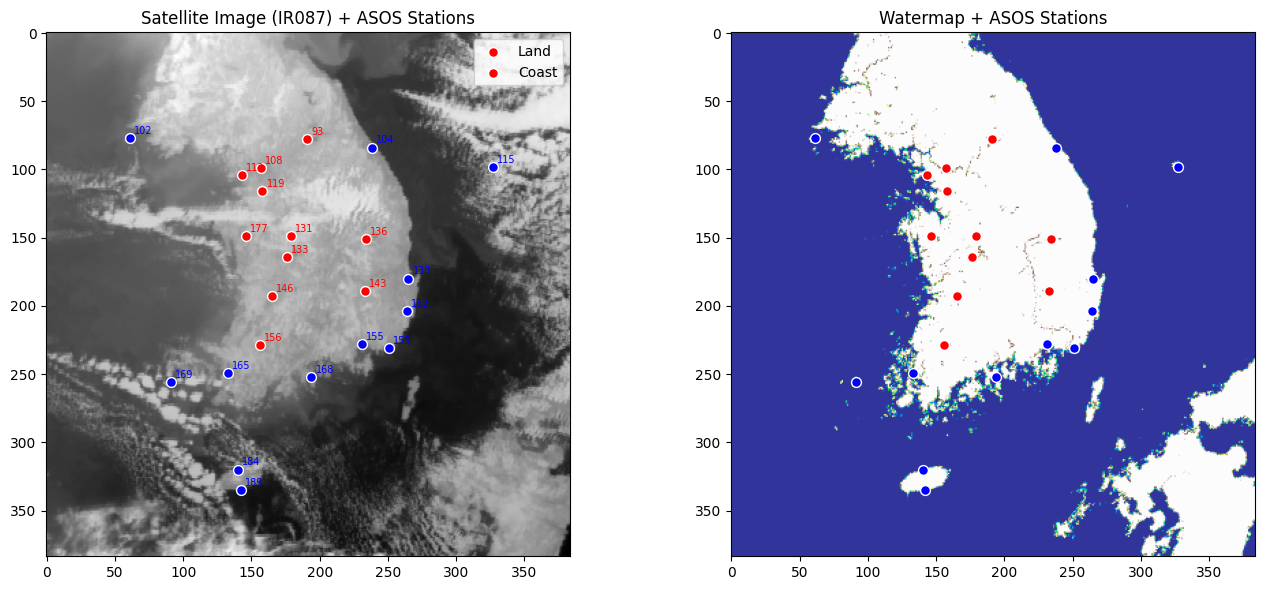


=== ASOS 좌표 범위 검증 ===
X 범위: 61 ~ 327 (이미지: 0~383)
Y 범위: 77 ~ 335 (이미지: 0~383)
범위 내 관측소: 23/23


In [9]:
# === 384x384 이미지 + ASOS 좌표 시각적 검증 ===
import numpy as np
import matplotlib.pyplot as plt

# 1. 샘플 위성 이미지 로드
sample_date = '20230101'
sample_file = f'{data_path}/{sample_date}/16ch_{sample_date}0600.npy'
sample_image = np.load(sample_file)  # (16, 384, 384)

# 2. IR 채널로 배경 표시
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 좌: 위성 이미지 + ASOS 위치
ax1 = axes[0]
ax1.imshow(sample_image[10], cmap='gray')  # IR087 채널
for k, (x, y) in asos_land_map.items():
    ax1.scatter(x, y, c='red', s=50, edgecolors='white', linewidth=1)
    ax1.annotate(str(k), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=7, color='red')
for k, (x, y) in asos_coast_map.items():
    ax1.scatter(x, y, c='blue', s=50, edgecolors='white', linewidth=1)
    ax1.annotate(str(k), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=7, color='blue')
ax1.set_title('Satellite Image (IR087) + ASOS Stations')
ax1.legend(['Land', 'Coast'], loc='upper right')

# 우: 지형 맵(watermap) + ASOS 위치
ax2 = axes[1]
# misc_images[2]가 watermap
watermap = misc_images[2].numpy() if torch.is_tensor(misc_images[2]) else misc_images[2]
ax2.imshow(-watermap + 1, cmap='terrain')
for k, (x, y) in asos_land_map.items():
    ax2.scatter(x, y, c='red', s=50, edgecolors='white', linewidth=1)
for k, (x, y) in asos_coast_map.items():
    ax2.scatter(x, y, c='blue', s=50, edgecolors='white', linewidth=1)
ax2.set_title('Watermap + ASOS Stations')

plt.tight_layout()
plt.show()

# 3. 좌표 범위 검증 출력
print("\n=== ASOS 좌표 범위 검증 ===")
all_coords = list(asos_land_map.values()) + list(asos_coast_map.values())
xs = [c[0] for c in all_coords]
ys = [c[1] for c in all_coords]
print(f"X 범위: {min(xs)} ~ {max(xs)} (이미지: 0~383)")
print(f"Y 범위: {min(ys)} ~ {max(ys)} (이미지: 0~383)")
print(f"범위 내 관측소: {sum(1 for x,y in all_coords if 0<=x<384 and 0<=y<384)}/23")

In [10]:
transform = transforms.Compose([
    transforms.Normalize(mean=total_mean, std=total_std)
])

train_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=train_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=patch_candidates, transform=transform, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

if ASOS:
    test_asos_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=test_asos_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=None, transform=transform, train=False)
    test_asos_dataloader = DataLoader(test_asos_dataset, batch_size=batch_size//2, shuffle=False, num_workers=num_workers, drop_last=False)


== Preparing asos...



Processing asos:   1%|▍                                          | 14/1277 [00:00<00:09, 135.55it/s]

  - 20200101 AM skipped, 2019-12-31 18:00:00 not in date_table


Processing asos:  51%|█████████████████████▎                    | 648/1277 [00:02<00:01, 422.26it/s]

  - 20211003 AM skipped, 2021-10-02 18:00:00 not in date_table


Processing asos: 100%|█████████████████████████████████████████| 1277/1277 [00:05<00:00, 234.82it/s]



  - Total 1275 image-label pairs prepared
  - train_asos_image_label_list.yaml saved

== asos dataset length synced to 1275
GK2A Dataset initialized


== Preparing asos...



Processing asos: 100%|███████████████████████████████████████████| 366/366 [00:01<00:00, 237.24it/s]



  - Total 366 image-label pairs prepared
  - test_asos_image_label_list.yaml saved

== asos dataset length synced to 366
GK2A Dataset initialized




Dataset patchfy set to True.

torch.Size([19, 384, 384]) torch.Size([23]) (2,)


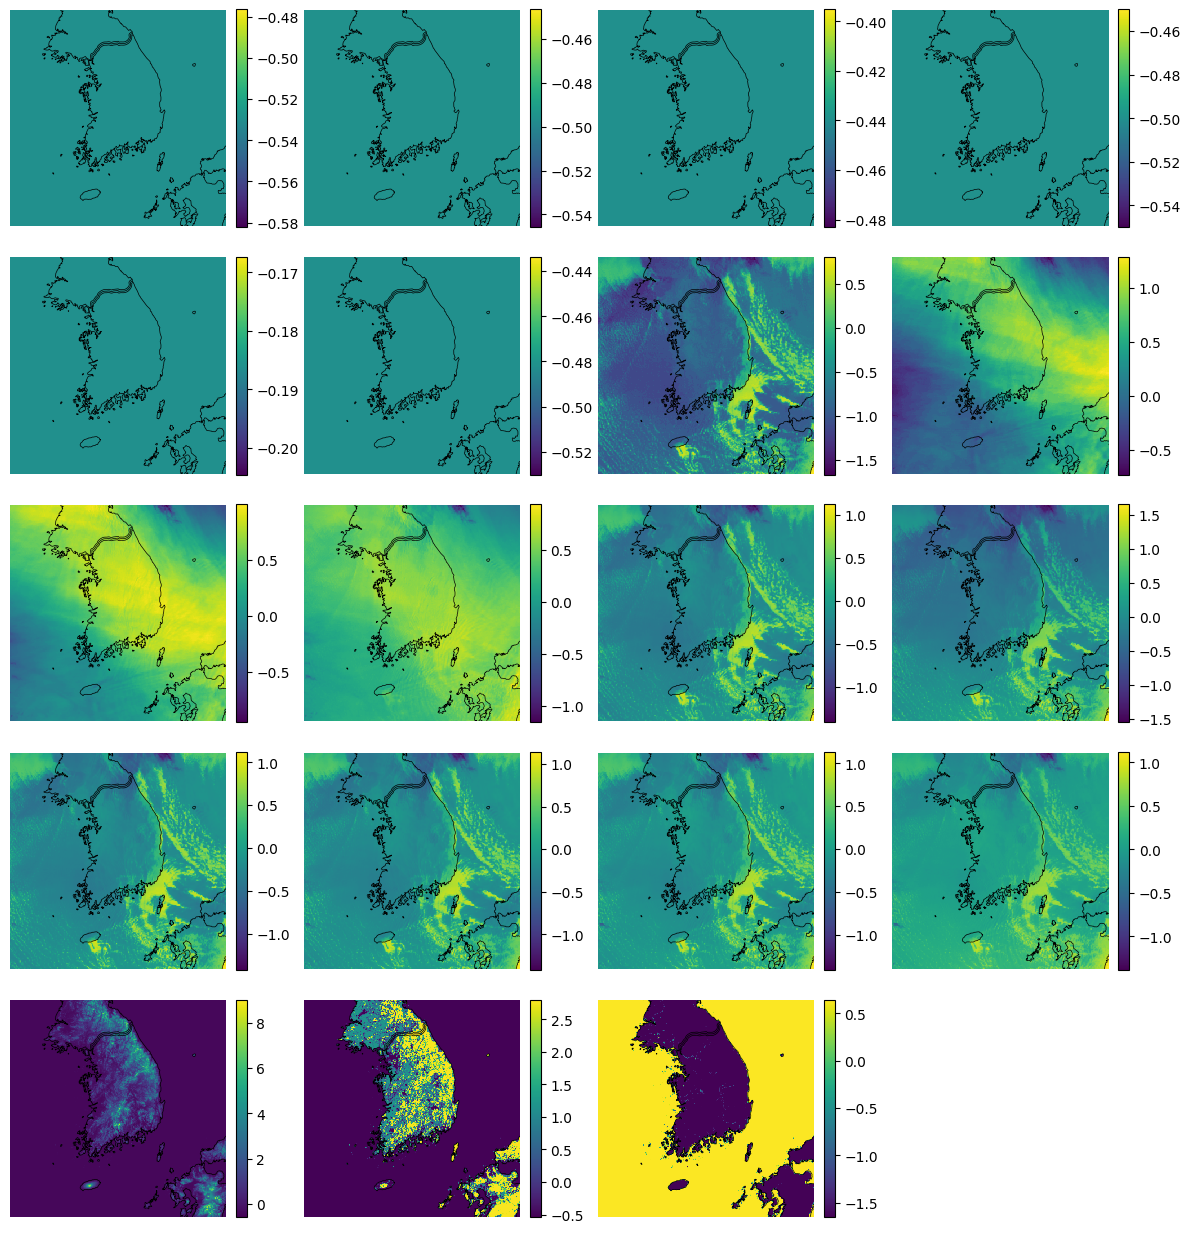

In [11]:
train_dataset.patchfy(True)
batch = train_dataset[7]
for i in range(len(batch)):
    images, label, coords = batch[i]
    print(images.shape, label.shape, coords.shape)

    fig, axs = plt.subplots(math.ceil(images.shape[0]/4), 4, figsize=(12, 2.5 * math.ceil(images.shape[0]/4)), subplot_kw={'projection': lcc})
    for i in range(len(axs.flatten())):
        ax = axs.flatten()[i]
        if i >= images.shape[0]:
            ax.axis('off')
            continue
        
        # channel = total_channels[i]
        # ax.set_title(channel)

        image = np.ones((asos_image_size, asos_image_size), dtype=np.float32)
        image *= -1.0
        image[coords[1]:coords[1]+patch_size, coords[0]:coords[0]+patch_size] = images[i].numpy()

        ax.set_aspect('equal')
        ax.axis('off')
        
        im = ax.pcolormesh(asos_lon, asos_lat, image, cmap='viridis', transform=proj)
            
        ax.coastlines(resolution='10m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()

In [12]:
model = get_model(total_channels, patch_size, class_num=2, model_type='deeplab')
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(19, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [13]:
def calc_measure_valid(Y_test, Y_test_hat, cutoff=0.5):
    Y_test = Y_test.ravel()
    Y_test_hat = Y_test_hat.ravel()
    
    Y_valid = (~np.isnan(Y_test))
    Y_test = Y_test[Y_valid]
    Y_test_hat = Y_test_hat[Y_valid]

    cfmat = confusion_matrix(Y_test, Y_test_hat > cutoff, labels = [0,1])
    acc = np.trace(cfmat) / np.sum(cfmat)
    csi = cfmat[1,1] /(np.sum(cfmat) - cfmat[0,0] + 1e-8)
    
    try:
        auroc = roc_auc_score(Y_test, Y_test_hat)
    except Exception as e:
        auroc = 0.0

    return csi, acc, auroc

In [14]:
def train(model, images, labels, coords, map_dict, cls_num=0):
    images = images.cuda()
    labels = labels.cuda()

    pred_map = model.forward(images)[:, cls_num] # B, H, W
    pred_vec = torch.zeros_like(labels)
    for b, (px, py) in enumerate(coords):
        for i, (x, y) in enumerate(map_dict.values()):
            if px <= x < px + patch_size and py <= y < py + patch_size:
                pred_vec[b, i] = pred_map[b, y - py, x - px]
            else:
                pred_vec[b, i] = labels[b, i]

    labels_valid = (~torch.isnan(labels)).float()
    labels = torch.nan_to_num(labels, 0.0)

    loss_focal_raw = sigmoid_focal_loss(pred_vec, labels, alpha=-1, gamma=2, reduction='none')
    loss_focal = (loss_focal_raw * labels_valid).sum() / labels_valid.sum().clamp(min=1.0)
    valid_any_batch = (labels_valid.sum() > 0)
    all_zero_batch = ((labels * labels_valid).sum() == 0)
                
    if not (valid_any_batch and all_zero_batch):
        loss_non_frost = torch.tensor(0.0, device=labels.device)
    else:
        loss_non_frost = binary_cross_entropy_with_logits(
                        pred_map, torch.zeros_like(pred_map), reduction='mean'
                    )

    tp = torch.sum(torch.sigmoid(pred_vec) * labels * labels_valid, dim=0)
    fn = torch.sum((1-torch.sigmoid(pred_vec)) * labels * labels_valid, dim=0)
    fp = torch.sum(torch.sigmoid(pred_vec) * (1-labels) * labels_valid, dim=0)
                
    loss_csi = torch.mean(-torch.log(tp + 1e-10) + torch.log(tp + fn + fp + 1e-10)) # csi = tp / (tp + fn + fp)

    return loss_focal + loss_non_frost + loss_csi
    

for seed in seeds:
    if os.path.exists(f'{output_path}/{seed}/ckpt.pt'):
        print(f'Seed {seed} already done. Skipping...')
        continue
    
    model = get_model(total_channels, patch_size)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay, gamma=lr_decay)

    start_epoch = 0
    
    results = dict(
            loss = {'asos': [], 'aafos': [], 'total': []},
            csi = {'asos': {}, 'aafos': {}},
            acc = {'asos': {}, 'aafos': {}},
            auroc = {'asos': [], 'aafos': []}, 
            
            best_asos = {},
            best_aafos = {},
            best_mean = {},
        )
    
    for cutoff_str in threshold:
        cutoff_str = str(cutoff_str)
        
        results['csi']['asos'][cutoff_str] = []
        results['acc']['asos'][cutoff_str] = []
        results['best_asos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['csi']['aafos'][cutoff_str] = []
        results['acc']['aafos'][cutoff_str] = []
        results['best_aafos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['best_mean'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
    
    if os.path.exists(f'{output_path}/{seed}/resume.pt'):
        resume = torch.load(f'{output_path}/{seed}/resume.pt')
        model.load_state_dict(resume['model'])
        optimizer.load_state_dict(resume['optimizer'])
        scheduler.load_state_dict(resume['scheduler'])
        start_epoch = resume['epoch'] + 1
        results = resume['results']
        print(f'Resuming from epoch {start_epoch}...')
    
    for epoch in range(start_epoch, epochs):
        model.train()
        
        total_loss_asos = 0.0
        total_loss_aafos = 0.0
        total_loss = 0.0
                
        # asos와 aafos 데이터셋 간 길이 맞춤 / 매 epoch마다 실행
        train_dataset.sync_dataset_length()
        for batch in tqdm(train_dataloader):
            if ASOS:
                images, label, coords = batch[0]
                loss_asos = train(model, images, label, coords, asos_map_dict, cls_num=0)
            else:
                loss_asos = torch.tensor(0.0).cuda()
            
            if AAFOS:
                images, label, coords = batch[1] if ASOS else batch[0]
                loss_aafos = train(model, images, label, coords, aafos_map_dict, cls_num=1)
            else:
                loss_aafos = torch.tensor(0.0).cuda()

            loss = asos_weight * loss_asos + aafos_weight * loss_aafos
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss_asos += loss_asos.item()
            total_loss_aafos += loss_aafos.item()
            total_loss += loss.item()

        total_loss_asos = total_loss_asos / len(train_dataloader)
        total_loss_aafos = total_loss_aafos / len(train_dataloader)
        total_loss = total_loss / len(train_dataloader)

        results['loss']['asos'].append(total_loss_asos)
        results['loss']['aafos'].append(total_loss_aafos)
        results['loss']['total'].append(total_loss)

        print(f'Epoch {epoch:2d} - Total Loss: {total_loss:.4f}, ASOS Loss: {total_loss_asos:.4f}, AAFOS Loss: {total_loss_aafos:.4f}')
        # epoch loop에 있으니까 -> 10, 20 epoch마다 lr decay
        scheduler.step()
    
        model.eval()
        with torch.no_grad():
            asos_results_per_threshold = {}
            
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                for batch in test_asos_dataloader:
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                    
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                for cutoff in threshold:
                    asos_result = calc_measure_valid(labels, pred_vecs, cutoff=cutoff)
                    csi, acc, auroc = asos_result[0], asos_result[1], asos_result[2]

                    cutoff_str = str(cutoff)
                    
                    results['csi']['asos'][cutoff_str].append(csi)
                    results['acc']['asos'][cutoff_str].append(acc)
                    
                    asos_results_per_threshold[cutoff_str] = asos_result
                    
                    is_best = csi > results['best_asos'][cutoff_str]['csi']
                    print(f'\t - ASOS  (T={cutoff:.2f}): CSI {csi:.4f}, AUROC {auroc:.4f} {"*" if is_best else ""}')
                    
                    if is_best:
                        results['best_asos'][cutoff_str]['csi'] = csi
                        results['best_asos'][cutoff_str]['epoch'] = epoch
                        results['best_asos'][cutoff_str]['model'] = model.state_dict()

                    asos_land_result = calc_measure_valid(labels[:,:11], pred_vecs[:,:11], cutoff=cutoff)
                    asos_coast_result = calc_measure_valid(labels[:,11:], pred_vecs[:,11:], cutoff=cutoff)
                    print(f'\t   - ASOS Land: CSI {asos_land_result[0]:.4f}, AUROC {asos_land_result[2]:.4f}')
                    print(f'\t   - ASOS Coast: CSI {asos_coast_result[0]:.4f}, AUROC {asos_coast_result[2]:.4f}')
                        
                results['auroc']['asos'].append(auroc)
                            
            print()
        
        resume = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch,
            'results': results
        }
        os.makedirs(f'{output_path}/{seed}', exist_ok=True)
        torch.save(resume, f'{output_path}/{seed}/resume.pt')
    
    torch.save(results, f'{output_path}/{seed}/ckpt.pt')
    os.remove(f'{output_path}/{seed}/resume.pt')

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  0 - Total Loss: 5.4448, ASOS Loss: 5.4448, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4181, AUROC 0.9317 *
	   - ASOS Land: CSI 0.4989, AUROC 0.9373
	   - ASOS Coast: CSI 0.2496, AUROC 0.8869

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  1 - Total Loss: 3.8843, ASOS Loss: 3.8843, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4501, AUROC 0.9434 *
	   - ASOS Land: CSI 0.5126, AUROC 0.9458
	   - ASOS Coast: CSI 0.2990, AUROC 0.9098

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  2 - Total Loss: 3.8916, ASOS Loss: 3.8916, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4572, AUROC 0.9495 *
	   - ASOS Land: CSI 0.5471, AUROC 0.9524
	   - ASOS Coast: CSI 0.2745, AUROC 0.9220

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  3 - Total Loss: 3.8018, ASOS Loss: 3.8018, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4380, AUROC 0.9477 
	   - ASOS Land: CSI 0.4694, AUROC 0.9468
	   - ASOS Coast: CSI 0.3363, AUROC 0.9267

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  4 - Total Loss: 3.3958, ASOS Loss: 3.3958, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4946, AUROC 0.9528 *
	   - ASOS Land: CSI 0.5822, AUROC 0.9583
	   - ASOS Coast: CSI 0.3049, AUROC 0.9190

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  5 - Total Loss: 3.3338, ASOS Loss: 3.3338, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4453, AUROC 0.9353 
	   - ASOS Land: CSI 0.5006, AUROC 0.9346
	   - ASOS Coast: CSI 0.3096, AUROC 0.9110

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  6 - Total Loss: 3.3407, ASOS Loss: 3.3407, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4099, AUROC 0.9266 
	   - ASOS Land: CSI 0.4647, AUROC 0.9247
	   - ASOS Coast: CSI 0.2394, AUROC 0.8943

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  7 - Total Loss: 3.7020, ASOS Loss: 3.7020, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4501, AUROC 0.9378 
	   - ASOS Land: CSI 0.5068, AUROC 0.9487
	   - ASOS Coast: CSI 0.2792, AUROC 0.8943

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  8 - Total Loss: 3.1038, ASOS Loss: 3.1038, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4153, AUROC 0.9341 
	   - ASOS Land: CSI 0.4582, AUROC 0.9301
	   - ASOS Coast: CSI 0.3026, AUROC 0.9013

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  9 - Total Loss: 3.1776, ASOS Loss: 3.1776, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3560, AUROC 0.9384 
	   - ASOS Land: CSI 0.4445, AUROC 0.9425
	   - ASOS Coast: CSI 0.2028, AUROC 0.9030

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch 10 - Total Loss: 3.2091, ASOS Loss: 3.2091, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5082, AUROC 0.9422 *
	   - ASOS Land: CSI 0.5802, AUROC 0.9481
	   - ASOS Coast: CSI 0.3318, AUROC 0.8998

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 11 - Total Loss: 3.5018, ASOS Loss: 3.5018, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5335, AUROC 0.9464 *
	   - ASOS Land: CSI 0.5925, AUROC 0.9526
	   - ASOS Coast: CSI 0.3624, AUROC 0.9043

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 12 - Total Loss: 3.3841, ASOS Loss: 3.3841, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5202, AUROC 0.9485 
	   - ASOS Land: CSI 0.5742, AUROC 0.9551
	   - ASOS Coast: CSI 0.3497, AUROC 0.9083

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 13 - Total Loss: 3.0362, ASOS Loss: 3.0362, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5337, AUROC 0.9491 *
	   - ASOS Land: CSI 0.5864, AUROC 0.9557
	   - ASOS Coast: CSI 0.3714, AUROC 0.9094

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 14 - Total Loss: 3.2121, ASOS Loss: 3.2121, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5321, AUROC 0.9493 
	   - ASOS Land: CSI 0.5860, AUROC 0.9556
	   - ASOS Coast: CSI 0.3547, AUROC 0.9109

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 15 - Total Loss: 3.1998, ASOS Loss: 3.1998, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5369, AUROC 0.9508 *
	   - ASOS Land: CSI 0.5957, AUROC 0.9563
	   - ASOS Coast: CSI 0.3512, AUROC 0.9143

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 16 - Total Loss: 3.1455, ASOS Loss: 3.1455, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5475, AUROC 0.9513 *
	   - ASOS Land: CSI 0.6025, AUROC 0.9570
	   - ASOS Coast: CSI 0.3727, AUROC 0.9153

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch 17 - Total Loss: 2.9491, ASOS Loss: 2.9491, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5409, AUROC 0.9496 
	   - ASOS Land: CSI 0.6036, AUROC 0.9555
	   - ASOS Coast: CSI 0.3344, AUROC 0.9130

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 18 - Total Loss: 2.8413, ASOS Loss: 2.8413, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5525, AUROC 0.9517 *
	   - ASOS Land: CSI 0.6100, AUROC 0.9575
	   - ASOS Coast: CSI 0.3692, AUROC 0.9155

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 19 - Total Loss: 3.0435, ASOS Loss: 3.0435, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5437, AUROC 0.9502 
	   - ASOS Land: CSI 0.5992, AUROC 0.9557
	   - ASOS Coast: CSI 0.3545, AUROC 0.9142

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 20 - Total Loss: 3.0462, ASOS Loss: 3.0462, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5355, AUROC 0.9505 
	   - ASOS Land: CSI 0.5870, AUROC 0.9560
	   - ASOS Coast: CSI 0.3628, AUROC 0.9148

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 21 - Total Loss: 2.9259, ASOS Loss: 2.9259, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5397, AUROC 0.9505 
	   - ASOS Land: CSI 0.5954, AUROC 0.9564
	   - ASOS Coast: CSI 0.3562, AUROC 0.9146

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 22 - Total Loss: 3.0194, ASOS Loss: 3.0194, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5405, AUROC 0.9499 
	   - ASOS Land: CSI 0.5977, AUROC 0.9559
	   - ASOS Coast: CSI 0.3503, AUROC 0.9137

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 23 - Total Loss: 3.5488, ASOS Loss: 3.5488, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5411, AUROC 0.9494 
	   - ASOS Land: CSI 0.6006, AUROC 0.9561
	   - ASOS Coast: CSI 0.3458, AUROC 0.9124

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 24 - Total Loss: 3.0871, ASOS Loss: 3.0871, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5387, AUROC 0.9495 
	   - ASOS Land: CSI 0.5960, AUROC 0.9560
	   - ASOS Coast: CSI 0.3489, AUROC 0.9127

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  0 - Total Loss: 5.4650, ASOS Loss: 5.4650, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.2830, AUROC 0.8751 *
	   - ASOS Land: CSI 0.3195, AUROC 0.8627
	   - ASOS Coast: CSI 0.1639, AUROC 0.8325

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  1 - Total Loss: 4.4112, ASOS Loss: 4.4112, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4331, AUROC 0.9413 *
	   - ASOS Land: CSI 0.4924, AUROC 0.9419
	   - ASOS Coast: CSI 0.2867, AUROC 0.9128

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  2 - Total Loss: 3.4702, ASOS Loss: 3.4702, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3669, AUROC 0.9245 
	   - ASOS Land: CSI 0.4261, AUROC 0.9189
	   - ASOS Coast: CSI 0.2349, AUROC 0.9025

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  3 - Total Loss: 3.6004, ASOS Loss: 3.6004, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4794, AUROC 0.9477 *
	   - ASOS Land: CSI 0.5505, AUROC 0.9524
	   - ASOS Coast: CSI 0.3141, AUROC 0.9100

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  4 - Total Loss: 3.4809, ASOS Loss: 3.4809, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4793, AUROC 0.9409 
	   - ASOS Land: CSI 0.5473, AUROC 0.9456
	   - ASOS Coast: CSI 0.2646, AUROC 0.9037

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  5 - Total Loss: 3.7806, ASOS Loss: 3.7806, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4424, AUROC 0.9497 
	   - ASOS Land: CSI 0.5110, AUROC 0.9544
	   - ASOS Coast: CSI 0.2815, AUROC 0.9127

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  6 - Total Loss: 3.3674, ASOS Loss: 3.3674, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4458, AUROC 0.9439 
	   - ASOS Land: CSI 0.5076, AUROC 0.9462
	   - ASOS Coast: CSI 0.2937, AUROC 0.9096

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  7 - Total Loss: 3.1121, ASOS Loss: 3.1121, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4974, AUROC 0.9419 *
	   - ASOS Land: CSI 0.5714, AUROC 0.9451
	   - ASOS Coast: CSI 0.3276, AUROC 0.9065

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  8 - Total Loss: 3.3804, ASOS Loss: 3.3804, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4845, AUROC 0.9477 
	   - ASOS Land: CSI 0.5410, AUROC 0.9509
	   - ASOS Coast: CSI 0.3382, AUROC 0.9114

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  9 - Total Loss: 3.2743, ASOS Loss: 3.2743, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5377, AUROC 0.9477 *
	   - ASOS Land: CSI 0.6071, AUROC 0.9524
	   - ASOS Coast: CSI 0.3511, AUROC 0.9141

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 10 - Total Loss: 3.1019, ASOS Loss: 3.1019, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5478, AUROC 0.9523 *
	   - ASOS Land: CSI 0.6190, AUROC 0.9588
	   - ASOS Coast: CSI 0.3560, AUROC 0.9168

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 11 - Total Loss: 3.0801, ASOS Loss: 3.0801, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5390, AUROC 0.9532 
	   - ASOS Land: CSI 0.6067, AUROC 0.9594
	   - ASOS Coast: CSI 0.3575, AUROC 0.9171

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 12 - Total Loss: 3.2457, ASOS Loss: 3.2457, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5414, AUROC 0.9533 
	   - ASOS Land: CSI 0.6032, AUROC 0.9588
	   - ASOS Coast: CSI 0.3668, AUROC 0.9177

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 13 - Total Loss: 3.2467, ASOS Loss: 3.2467, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5185, AUROC 0.9533 
	   - ASOS Land: CSI 0.5785, AUROC 0.9584
	   - ASOS Coast: CSI 0.3614, AUROC 0.9194

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 14 - Total Loss: 3.3165, ASOS Loss: 3.3165, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5215, AUROC 0.9523 
	   - ASOS Land: CSI 0.5717, AUROC 0.9558
	   - ASOS Coast: CSI 0.3720, AUROC 0.9199

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 15 - Total Loss: 3.0808, ASOS Loss: 3.0808, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5479, AUROC 0.9511 *
	   - ASOS Land: CSI 0.6107, AUROC 0.9553
	   - ASOS Coast: CSI 0.3787, AUROC 0.9182

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 16 - Total Loss: 2.8148, ASOS Loss: 2.8148, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5409, AUROC 0.9538 
	   - ASOS Land: CSI 0.5963, AUROC 0.9585
	   - ASOS Coast: CSI 0.3787, AUROC 0.9203

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 17 - Total Loss: 2.8249, ASOS Loss: 2.8249, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5204, AUROC 0.9518 
	   - ASOS Land: CSI 0.5682, AUROC 0.9553
	   - ASOS Coast: CSI 0.3720, AUROC 0.9181

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:38<00:00,  2.04s/it]

Epoch 18 - Total Loss: 3.0965, ASOS Loss: 3.0965, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5307, AUROC 0.9511 
	   - ASOS Land: CSI 0.5887, AUROC 0.9565
	   - ASOS Coast: CSI 0.3656, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 19 - Total Loss: 2.6434, ASOS Loss: 2.6434, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5396, AUROC 0.9516 
	   - ASOS Land: CSI 0.5941, AUROC 0.9562
	   - ASOS Coast: CSI 0.3761, AUROC 0.9168

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 20 - Total Loss: 3.0255, ASOS Loss: 3.0255, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5411, AUROC 0.9511 
	   - ASOS Land: CSI 0.5966, AUROC 0.9553
	   - ASOS Coast: CSI 0.3764, AUROC 0.9170

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 21 - Total Loss: 2.7777, ASOS Loss: 2.7777, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5375, AUROC 0.9517 
	   - ASOS Land: CSI 0.5907, AUROC 0.9560
	   - ASOS Coast: CSI 0.3778, AUROC 0.9178

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 22 - Total Loss: 3.0770, ASOS Loss: 3.0770, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5367, AUROC 0.9519 
	   - ASOS Land: CSI 0.5878, AUROC 0.9563
	   - ASOS Coast: CSI 0.3829, AUROC 0.9183

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 23 - Total Loss: 2.6581, ASOS Loss: 2.6581, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5393, AUROC 0.9510 
	   - ASOS Land: CSI 0.5926, AUROC 0.9550
	   - ASOS Coast: CSI 0.3808, AUROC 0.9176

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 24 - Total Loss: 3.0534, ASOS Loss: 3.0534, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5391, AUROC 0.9516 
	   - ASOS Land: CSI 0.5894, AUROC 0.9558
	   - ASOS Coast: CSI 0.3853, AUROC 0.9182

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  0 - Total Loss: 5.3595, ASOS Loss: 5.3595, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3397, AUROC 0.9187 *
	   - ASOS Land: CSI 0.4342, AUROC 0.9198
	   - ASOS Coast: CSI 0.1821, AUROC 0.8720

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  1 - Total Loss: 4.1847, ASOS Loss: 4.1847, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3907, AUROC 0.9318 *
	   - ASOS Land: CSI 0.4771, AUROC 0.9304
	   - ASOS Coast: CSI 0.2285, AUROC 0.9079

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  2 - Total Loss: 3.8169, ASOS Loss: 3.8169, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4537, AUROC 0.9398 *
	   - ASOS Land: CSI 0.5071, AUROC 0.9427
	   - ASOS Coast: CSI 0.3158, AUROC 0.9012

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  3 - Total Loss: 3.4744, ASOS Loss: 3.4744, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5068, AUROC 0.9411 *
	   - ASOS Land: CSI 0.5855, AUROC 0.9491
	   - ASOS Coast: CSI 0.2922, AUROC 0.8972

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  4 - Total Loss: 3.6398, ASOS Loss: 3.6398, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4928, AUROC 0.9431 
	   - ASOS Land: CSI 0.5642, AUROC 0.9489
	   - ASOS Coast: CSI 0.3220, AUROC 0.9096

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  5 - Total Loss: 3.6772, ASOS Loss: 3.6772, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4960, AUROC 0.9396 
	   - ASOS Land: CSI 0.5599, AUROC 0.9479
	   - ASOS Coast: CSI 0.3127, AUROC 0.8950

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  6 - Total Loss: 3.6451, ASOS Loss: 3.6451, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4963, AUROC 0.9415 
	   - ASOS Land: CSI 0.5662, AUROC 0.9477
	   - ASOS Coast: CSI 0.3171, AUROC 0.9023

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  7 - Total Loss: 3.1570, ASOS Loss: 3.1570, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4283, AUROC 0.9372 
	   - ASOS Land: CSI 0.4723, AUROC 0.9369
	   - ASOS Coast: CSI 0.2964, AUROC 0.9011

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  8 - Total Loss: 3.5871, ASOS Loss: 3.5871, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3624, AUROC 0.9453 
	   - ASOS Land: CSI 0.4490, AUROC 0.9502
	   - ASOS Coast: CSI 0.2119, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  9 - Total Loss: 3.4591, ASOS Loss: 3.4591, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4991, AUROC 0.9473 
	   - ASOS Land: CSI 0.5570, AUROC 0.9521
	   - ASOS Coast: CSI 0.3403, AUROC 0.9083

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 10 - Total Loss: 3.1304, ASOS Loss: 3.1304, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4988, AUROC 0.9486 
	   - ASOS Land: CSI 0.5597, AUROC 0.9542
	   - ASOS Coast: CSI 0.3406, AUROC 0.9104

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 11 - Total Loss: 3.1118, ASOS Loss: 3.1118, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5240, AUROC 0.9495 *
	   - ASOS Land: CSI 0.5887, AUROC 0.9554
	   - ASOS Coast: CSI 0.3555, AUROC 0.9112

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 12 - Total Loss: 3.1361, ASOS Loss: 3.1361, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5307, AUROC 0.9498 *
	   - ASOS Land: CSI 0.5930, AUROC 0.9552
	   - ASOS Coast: CSI 0.3630, AUROC 0.9122

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.98s/it]

Epoch 13 - Total Loss: 3.1452, ASOS Loss: 3.1452, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5269, AUROC 0.9505 
	   - ASOS Land: CSI 0.5897, AUROC 0.9561
	   - ASOS Coast: CSI 0.3566, AUROC 0.9129

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 14 - Total Loss: 2.8508, ASOS Loss: 2.8508, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5152, AUROC 0.9506 
	   - ASOS Land: CSI 0.5680, AUROC 0.9546
	   - ASOS Coast: CSI 0.3676, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 15 - Total Loss: 3.2866, ASOS Loss: 3.2866, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5192, AUROC 0.9506 
	   - ASOS Land: CSI 0.5818, AUROC 0.9551
	   - ASOS Coast: CSI 0.3524, AUROC 0.9142

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 16 - Total Loss: 3.0096, ASOS Loss: 3.0096, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5324, AUROC 0.9509 *
	   - ASOS Land: CSI 0.5927, AUROC 0.9552
	   - ASOS Coast: CSI 0.3673, AUROC 0.9152

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch 17 - Total Loss: 3.0642, ASOS Loss: 3.0642, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5294, AUROC 0.9504 
	   - ASOS Land: CSI 0.5899, AUROC 0.9549
	   - ASOS Coast: CSI 0.3636, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 18 - Total Loss: 3.1591, ASOS Loss: 3.1591, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5298, AUROC 0.9501 
	   - ASOS Land: CSI 0.5833, AUROC 0.9542
	   - ASOS Coast: CSI 0.3773, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 19 - Total Loss: 2.8317, ASOS Loss: 2.8317, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5349, AUROC 0.9505 *
	   - ASOS Land: CSI 0.5930, AUROC 0.9550
	   - ASOS Coast: CSI 0.3734, AUROC 0.9147

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 20 - Total Loss: 3.0259, ASOS Loss: 3.0259, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5290, AUROC 0.9501 
	   - ASOS Land: CSI 0.5874, AUROC 0.9544
	   - ASOS Coast: CSI 0.3691, AUROC 0.9146

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 21 - Total Loss: 3.0724, ASOS Loss: 3.0724, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5317, AUROC 0.9506 
	   - ASOS Land: CSI 0.5912, AUROC 0.9552
	   - ASOS Coast: CSI 0.3687, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch 22 - Total Loss: 3.0094, ASOS Loss: 3.0094, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5295, AUROC 0.9502 
	   - ASOS Land: CSI 0.5883, AUROC 0.9546
	   - ASOS Coast: CSI 0.3684, AUROC 0.9145

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 23 - Total Loss: 2.9132, ASOS Loss: 2.9132, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5222, AUROC 0.9506 
	   - ASOS Land: CSI 0.5798, AUROC 0.9551
	   - ASOS Coast: CSI 0.3632, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 24 - Total Loss: 2.8757, ASOS Loss: 2.8757, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5311, AUROC 0.9505 
	   - ASOS Land: CSI 0.5890, AUROC 0.9551
	   - ASOS Coast: CSI 0.3692, AUROC 0.9147

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  0 - Total Loss: 5.3420, ASOS Loss: 5.3420, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3973, AUROC 0.9151 *
	   - ASOS Land: CSI 0.4547, AUROC 0.9057
	   - ASOS Coast: CSI 0.2647, AUROC 0.8845

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  1 - Total Loss: 4.2403, ASOS Loss: 4.2403, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4346, AUROC 0.9476 *
	   - ASOS Land: CSI 0.5118, AUROC 0.9445
	   - ASOS Coast: CSI 0.2670, AUROC 0.9230

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  2 - Total Loss: 3.5885, ASOS Loss: 3.5885, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4650, AUROC 0.9422 *
	   - ASOS Land: CSI 0.5205, AUROC 0.9440
	   - ASOS Coast: CSI 0.3191, AUROC 0.9095

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  3 - Total Loss: 3.5649, ASOS Loss: 3.5649, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4065, AUROC 0.9452 
	   - ASOS Land: CSI 0.4728, AUROC 0.9480
	   - ASOS Coast: CSI 0.2594, AUROC 0.9082

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  4 - Total Loss: 3.8007, ASOS Loss: 3.8007, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5074, AUROC 0.9389 *
	   - ASOS Land: CSI 0.5840, AUROC 0.9503
	   - ASOS Coast: CSI 0.2113, AUROC 0.8974

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  5 - Total Loss: 3.2653, ASOS Loss: 3.2653, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4503, AUROC 0.9435 
	   - ASOS Land: CSI 0.4974, AUROC 0.9471
	   - ASOS Coast: CSI 0.3225, AUROC 0.9047

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  6 - Total Loss: 3.3979, ASOS Loss: 3.3979, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3842, AUROC 0.9477 
	   - ASOS Land: CSI 0.4422, AUROC 0.9536
	   - ASOS Coast: CSI 0.2549, AUROC 0.9101

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  7 - Total Loss: 3.2049, ASOS Loss: 3.2049, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4986, AUROC 0.9419 
	   - ASOS Land: CSI 0.5611, AUROC 0.9457
	   - ASOS Coast: CSI 0.3358, AUROC 0.9029

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch  8 - Total Loss: 3.2155, ASOS Loss: 3.2155, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4957, AUROC 0.9491 
	   - ASOS Land: CSI 0.5574, AUROC 0.9553
	   - ASOS Coast: CSI 0.3355, AUROC 0.9105

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  9 - Total Loss: 3.2279, ASOS Loss: 3.2279, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4142, AUROC 0.9441 
	   - ASOS Land: CSI 0.4906, AUROC 0.9491
	   - ASOS Coast: CSI 0.2595, AUROC 0.9113

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 10 - Total Loss: 3.3384, ASOS Loss: 3.3384, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5000, AUROC 0.9495 
	   - ASOS Land: CSI 0.5741, AUROC 0.9541
	   - ASOS Coast: CSI 0.3265, AUROC 0.9136

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 11 - Total Loss: 3.0667, ASOS Loss: 3.0667, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5286, AUROC 0.9514 *
	   - ASOS Land: CSI 0.5956, AUROC 0.9563
	   - ASOS Coast: CSI 0.3568, AUROC 0.9146

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 12 - Total Loss: 3.3998, ASOS Loss: 3.3998, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5367, AUROC 0.9523 *
	   - ASOS Land: CSI 0.6021, AUROC 0.9577
	   - ASOS Coast: CSI 0.3609, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 13 - Total Loss: 3.1280, ASOS Loss: 3.1280, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5364, AUROC 0.9522 
	   - ASOS Land: CSI 0.6039, AUROC 0.9581
	   - ASOS Coast: CSI 0.3571, AUROC 0.9148

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 14 - Total Loss: 3.2563, ASOS Loss: 3.2563, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5376, AUROC 0.9524 *
	   - ASOS Land: CSI 0.6036, AUROC 0.9581
	   - ASOS Coast: CSI 0.3602, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 15 - Total Loss: 3.4291, ASOS Loss: 3.4291, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5379, AUROC 0.9527 *
	   - ASOS Land: CSI 0.6002, AUROC 0.9588
	   - ASOS Coast: CSI 0.3673, AUROC 0.9154

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 16 - Total Loss: 2.8881, ASOS Loss: 2.8881, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5369, AUROC 0.9530 
	   - ASOS Land: CSI 0.6019, AUROC 0.9592
	   - ASOS Coast: CSI 0.3602, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 17 - Total Loss: 3.0707, ASOS Loss: 3.0707, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5379, AUROC 0.9528 *
	   - ASOS Land: CSI 0.6051, AUROC 0.9586
	   - ASOS Coast: CSI 0.3517, AUROC 0.9167

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 18 - Total Loss: 3.2086, ASOS Loss: 3.2086, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5362, AUROC 0.9528 
	   - ASOS Land: CSI 0.5951, AUROC 0.9579
	   - ASOS Coast: CSI 0.3697, AUROC 0.9179

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 19 - Total Loss: 3.1704, ASOS Loss: 3.1704, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5479, AUROC 0.9528 *
	   - ASOS Land: CSI 0.6129, AUROC 0.9574
	   - ASOS Coast: CSI 0.3592, AUROC 0.9175

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 20 - Total Loss: 2.9115, ASOS Loss: 2.9115, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5448, AUROC 0.9531 
	   - ASOS Land: CSI 0.6030, AUROC 0.9578
	   - ASOS Coast: CSI 0.3764, AUROC 0.9181

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 21 - Total Loss: 2.8085, ASOS Loss: 2.8085, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5391, AUROC 0.9530 
	   - ASOS Land: CSI 0.5970, AUROC 0.9578
	   - ASOS Coast: CSI 0.3747, AUROC 0.9181

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 22 - Total Loss: 2.8146, ASOS Loss: 2.8146, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5354, AUROC 0.9528 
	   - ASOS Land: CSI 0.5945, AUROC 0.9575
	   - ASOS Coast: CSI 0.3688, AUROC 0.9178

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 23 - Total Loss: 2.9969, ASOS Loss: 2.9969, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5409, AUROC 0.9534 
	   - ASOS Land: CSI 0.5987, AUROC 0.9583
	   - ASOS Coast: CSI 0.3753, AUROC 0.9184

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.95s/it]

Epoch 24 - Total Loss: 2.9137, ASOS Loss: 2.9137, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5464, AUROC 0.9536 
	   - ASOS Land: CSI 0.6023, AUROC 0.9585
	   - ASOS Coast: CSI 0.3840, AUROC 0.9186

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  0 - Total Loss: 5.4200, ASOS Loss: 5.4200, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4752, AUROC 0.9238 *
	   - ASOS Land: CSI 0.5373, AUROC 0.9237
	   - ASOS Coast: CSI 0.2778, AUROC 0.8819

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  1 - Total Loss: 3.9264, ASOS Loss: 3.9264, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3927, AUROC 0.9387 
	   - ASOS Land: CSI 0.4625, AUROC 0.9373
	   - ASOS Coast: CSI 0.2479, AUROC 0.9126

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  2 - Total Loss: 3.3964, ASOS Loss: 3.3964, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4616, AUROC 0.9413 
	   - ASOS Land: CSI 0.5145, AUROC 0.9443
	   - ASOS Coast: CSI 0.3037, AUROC 0.9041

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  3 - Total Loss: 3.5775, ASOS Loss: 3.5775, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4609, AUROC 0.9505 
	   - ASOS Land: CSI 0.5143, AUROC 0.9480
	   - ASOS Coast: CSI 0.3219, AUROC 0.9277

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  4 - Total Loss: 3.4950, ASOS Loss: 3.4950, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4621, AUROC 0.9169 
	   - ASOS Land: CSI 0.5160, AUROC 0.9099
	   - ASOS Coast: CSI 0.3306, AUROC 0.8942

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  5 - Total Loss: 3.5412, ASOS Loss: 3.5412, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5263, AUROC 0.9495 *
	   - ASOS Land: CSI 0.5920, AUROC 0.9488
	   - ASOS Coast: CSI 0.3478, AUROC 0.9286

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  6 - Total Loss: 3.1925, ASOS Loss: 3.1925, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3775, AUROC 0.9240 
	   - ASOS Land: CSI 0.4259, AUROC 0.9174
	   - ASOS Coast: CSI 0.2325, AUROC 0.8925

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.91s/it]

Epoch  7 - Total Loss: 3.3138, ASOS Loss: 3.3138, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5115, AUROC 0.9528 
	   - ASOS Land: CSI 0.5894, AUROC 0.9533
	   - ASOS Coast: CSI 0.3312, AUROC 0.9293

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  8 - Total Loss: 3.3534, ASOS Loss: 3.3534, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4902, AUROC 0.9489 
	   - ASOS Land: CSI 0.5641, AUROC 0.9486
	   - ASOS Coast: CSI 0.3140, AUROC 0.9213

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  9 - Total Loss: 3.2375, ASOS Loss: 3.2375, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4484, AUROC 0.9470 
	   - ASOS Land: CSI 0.4908, AUROC 0.9518
	   - ASOS Coast: CSI 0.3095, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 10 - Total Loss: 3.1405, ASOS Loss: 3.1405, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5000, AUROC 0.9518 
	   - ASOS Land: CSI 0.5550, AUROC 0.9552
	   - ASOS Coast: CSI 0.3451, AUROC 0.9220

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 11 - Total Loss: 3.4612, ASOS Loss: 3.4612, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5193, AUROC 0.9526 
	   - ASOS Land: CSI 0.5799, AUROC 0.9569
	   - ASOS Coast: CSI 0.3460, AUROC 0.9205

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 12 - Total Loss: 3.1426, ASOS Loss: 3.1426, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5277, AUROC 0.9507 *
	   - ASOS Land: CSI 0.5983, AUROC 0.9563
	   - ASOS Coast: CSI 0.3350, AUROC 0.9151

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 13 - Total Loss: 3.1231, ASOS Loss: 3.1231, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5255, AUROC 0.9485 
	   - ASOS Land: CSI 0.5894, AUROC 0.9554
	   - ASOS Coast: CSI 0.3305, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 14 - Total Loss: 3.1476, ASOS Loss: 3.1476, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5274, AUROC 0.9458 
	   - ASOS Land: CSI 0.5969, AUROC 0.9552
	   - ASOS Coast: CSI 0.3179, AUROC 0.9037

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 15 - Total Loss: 2.8661, ASOS Loss: 2.8661, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5290, AUROC 0.9484 *
	   - ASOS Land: CSI 0.5967, AUROC 0.9572
	   - ASOS Coast: CSI 0.3342, AUROC 0.9076

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 16 - Total Loss: 3.0230, ASOS Loss: 3.0230, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5119, AUROC 0.9451 
	   - ASOS Land: CSI 0.5830, AUROC 0.9538
	   - ASOS Coast: CSI 0.3263, AUROC 0.9018

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 17 - Total Loss: 2.9573, ASOS Loss: 2.9573, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4933, AUROC 0.9430 
	   - ASOS Land: CSI 0.5476, AUROC 0.9494
	   - ASOS Coast: CSI 0.3200, AUROC 0.9006

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 18 - Total Loss: 3.1184, ASOS Loss: 3.1184, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5321, AUROC 0.9459 *
	   - ASOS Land: CSI 0.6000, AUROC 0.9508
	   - ASOS Coast: CSI 0.3475, AUROC 0.9113

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 19 - Total Loss: 2.9716, ASOS Loss: 2.9716, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5157, AUROC 0.9440 
	   - ASOS Land: CSI 0.5775, AUROC 0.9531
	   - ASOS Coast: CSI 0.3187, AUROC 0.9015

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 20 - Total Loss: 3.1583, ASOS Loss: 3.1583, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5172, AUROC 0.9445 
	   - ASOS Land: CSI 0.5804, AUROC 0.9523
	   - ASOS Coast: CSI 0.3201, AUROC 0.9040

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 21 - Total Loss: 2.6102, ASOS Loss: 2.6102, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5204, AUROC 0.9462 
	   - ASOS Land: CSI 0.5822, AUROC 0.9531
	   - ASOS Coast: CSI 0.3324, AUROC 0.9080

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 22 - Total Loss: 2.8098, ASOS Loss: 2.8098, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5181, AUROC 0.9459 
	   - ASOS Land: CSI 0.5786, AUROC 0.9533
	   - ASOS Coast: CSI 0.3343, AUROC 0.9069

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 23 - Total Loss: 2.5590, ASOS Loss: 2.5590, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5164, AUROC 0.9453 
	   - ASOS Land: CSI 0.5758, AUROC 0.9536
	   - ASOS Coast: CSI 0.3263, AUROC 0.9044

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 24 - Total Loss: 3.1293, ASOS Loss: 3.1293, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5206, AUROC 0.9452 
	   - ASOS Land: CSI 0.5829, AUROC 0.9532
	   - ASOS Coast: CSI 0.3266, AUROC 0.9052

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  0 - Total Loss: 5.4403, ASOS Loss: 5.4403, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4120, AUROC 0.9281 *
	   - ASOS Land: CSI 0.5160, AUROC 0.9266
	   - ASOS Coast: CSI 0.2323, AUROC 0.8987

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  1 - Total Loss: 3.8583, ASOS Loss: 3.8583, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3107, AUROC 0.9258 
	   - ASOS Land: CSI 0.3875, AUROC 0.9165
	   - ASOS Coast: CSI 0.1778, AUROC 0.9022

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  2 - Total Loss: 3.7166, ASOS Loss: 3.7166, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4791, AUROC 0.9434 *
	   - ASOS Land: CSI 0.5395, AUROC 0.9462
	   - ASOS Coast: CSI 0.3278, AUROC 0.9075

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  3 - Total Loss: 3.5813, ASOS Loss: 3.5813, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4288, AUROC 0.9498 
	   - ASOS Land: CSI 0.5178, AUROC 0.9531
	   - ASOS Coast: CSI 0.2530, AUROC 0.9177

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  4 - Total Loss: 3.4698, ASOS Loss: 3.4698, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4619, AUROC 0.9490 
	   - ASOS Land: CSI 0.5379, AUROC 0.9498
	   - ASOS Coast: CSI 0.2985, AUROC 0.9237

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  5 - Total Loss: 3.1766, ASOS Loss: 3.1766, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4425, AUROC 0.9564 
	   - ASOS Land: CSI 0.5029, AUROC 0.9551
	   - ASOS Coast: CSI 0.3002, AUROC 0.9330

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  6 - Total Loss: 3.5652, ASOS Loss: 3.5652, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4710, AUROC 0.9470 
	   - ASOS Land: CSI 0.5238, AUROC 0.9476
	   - ASOS Coast: CSI 0.3131, AUROC 0.9167

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  7 - Total Loss: 3.5962, ASOS Loss: 3.5962, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4512, AUROC 0.9496 
	   - ASOS Land: CSI 0.4996, AUROC 0.9533
	   - ASOS Coast: CSI 0.3217, AUROC 0.9147

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  8 - Total Loss: 3.1523, ASOS Loss: 3.1523, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4188, AUROC 0.9316 
	   - ASOS Land: CSI 0.4655, AUROC 0.9260
	   - ASOS Coast: CSI 0.2963, AUROC 0.9021

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  9 - Total Loss: 3.2641, ASOS Loss: 3.2641, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4791, AUROC 0.9509 
	   - ASOS Land: CSI 0.5411, AUROC 0.9578
	   - ASOS Coast: CSI 0.3253, AUROC 0.9146

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 10 - Total Loss: 2.8895, ASOS Loss: 2.8895, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5104, AUROC 0.9524 *
	   - ASOS Land: CSI 0.5846, AUROC 0.9592
	   - ASOS Coast: CSI 0.3305, AUROC 0.9161

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 11 - Total Loss: 2.9379, ASOS Loss: 2.9379, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5341, AUROC 0.9529 *
	   - ASOS Land: CSI 0.5947, AUROC 0.9584
	   - ASOS Coast: CSI 0.3668, AUROC 0.9169

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 12 - Total Loss: 3.1631, ASOS Loss: 3.1631, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5280, AUROC 0.9530 
	   - ASOS Land: CSI 0.5910, AUROC 0.9585
	   - ASOS Coast: CSI 0.3617, AUROC 0.9177

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 13 - Total Loss: 3.0608, ASOS Loss: 3.0608, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5304, AUROC 0.9534 
	   - ASOS Land: CSI 0.5924, AUROC 0.9590
	   - ASOS Coast: CSI 0.3667, AUROC 0.9179

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 14 - Total Loss: 2.6853, ASOS Loss: 2.6853, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5289, AUROC 0.9536 
	   - ASOS Land: CSI 0.5922, AUROC 0.9590
	   - ASOS Coast: CSI 0.3601, AUROC 0.9182

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 15 - Total Loss: 2.9350, ASOS Loss: 2.9350, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5368, AUROC 0.9534 *
	   - ASOS Land: CSI 0.6064, AUROC 0.9588
	   - ASOS Coast: CSI 0.3547, AUROC 0.9178

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 16 - Total Loss: 3.2689, ASOS Loss: 3.2689, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5403, AUROC 0.9536 *
	   - ASOS Land: CSI 0.6007, AUROC 0.9583
	   - ASOS Coast: CSI 0.3641, AUROC 0.9184

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 17 - Total Loss: 2.9072, ASOS Loss: 2.9072, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5440, AUROC 0.9546 *
	   - ASOS Land: CSI 0.6087, AUROC 0.9601
	   - ASOS Coast: CSI 0.3692, AUROC 0.9197

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 18 - Total Loss: 2.9534, ASOS Loss: 2.9534, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5543, AUROC 0.9550 *
	   - ASOS Land: CSI 0.6123, AUROC 0.9600
	   - ASOS Coast: CSI 0.3898, AUROC 0.9205

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 19 - Total Loss: 2.9467, ASOS Loss: 2.9467, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5483, AUROC 0.9543 
	   - ASOS Land: CSI 0.6123, AUROC 0.9595
	   - ASOS Coast: CSI 0.3763, AUROC 0.9199

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 20 - Total Loss: 2.8661, ASOS Loss: 2.8661, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5372, AUROC 0.9542 
	   - ASOS Land: CSI 0.6026, AUROC 0.9595
	   - ASOS Coast: CSI 0.3650, AUROC 0.9199

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 21 - Total Loss: 2.9796, ASOS Loss: 2.9796, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5430, AUROC 0.9546 
	   - ASOS Land: CSI 0.6000, AUROC 0.9598
	   - ASOS Coast: CSI 0.3848, AUROC 0.9203

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 22 - Total Loss: 2.9038, ASOS Loss: 2.9038, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5414, AUROC 0.9541 
	   - ASOS Land: CSI 0.6000, AUROC 0.9590
	   - ASOS Coast: CSI 0.3801, AUROC 0.9201

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 23 - Total Loss: 3.1028, ASOS Loss: 3.1028, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5533, AUROC 0.9546 
	   - ASOS Land: CSI 0.6116, AUROC 0.9597
	   - ASOS Coast: CSI 0.3889, AUROC 0.9203

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 24 - Total Loss: 3.1297, ASOS Loss: 3.1297, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5426, AUROC 0.9544 
	   - ASOS Land: CSI 0.6018, AUROC 0.9594
	   - ASOS Coast: CSI 0.3769, AUROC 0.9201

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  0 - Total Loss: 5.2167, ASOS Loss: 5.2167, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3616, AUROC 0.9059 *
	   - ASOS Land: CSI 0.4560, AUROC 0.9063
	   - ASOS Coast: CSI 0.2117, AUROC 0.8855

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  1 - Total Loss: 3.7512, ASOS Loss: 3.7512, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4017, AUROC 0.9222 *
	   - ASOS Land: CSI 0.4662, AUROC 0.9170
	   - ASOS Coast: CSI 0.2228, AUROC 0.8944

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  2 - Total Loss: 3.9657, ASOS Loss: 3.9657, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5331, AUROC 0.9406 *
	   - ASOS Land: CSI 0.5897, AUROC 0.9425
	   - ASOS Coast: CSI 0.3548, AUROC 0.9079

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  3 - Total Loss: 3.5339, ASOS Loss: 3.5339, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4742, AUROC 0.9350 
	   - ASOS Land: CSI 0.5588, AUROC 0.9392
	   - ASOS Coast: CSI 0.2775, AUROC 0.8934

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  4 - Total Loss: 3.3791, ASOS Loss: 3.3791, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3581, AUROC 0.9487 
	   - ASOS Land: CSI 0.4519, AUROC 0.9479
	   - ASOS Coast: CSI 0.2013, AUROC 0.9206

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  5 - Total Loss: 3.8163, ASOS Loss: 3.8163, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4317, AUROC 0.9346 
	   - ASOS Land: CSI 0.4650, AUROC 0.9371
	   - ASOS Coast: CSI 0.3112, AUROC 0.9013

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  6 - Total Loss: 3.3804, ASOS Loss: 3.3804, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4427, AUROC 0.9415 
	   - ASOS Land: CSI 0.4933, AUROC 0.9432
	   - ASOS Coast: CSI 0.3074, AUROC 0.9086

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  7 - Total Loss: 3.4965, ASOS Loss: 3.4965, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4881, AUROC 0.9212 
	   - ASOS Land: CSI 0.5482, AUROC 0.9171
	   - ASOS Coast: CSI 0.3325, AUROC 0.8861

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  8 - Total Loss: 3.2913, ASOS Loss: 3.2913, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4196, AUROC 0.9401 
	   - ASOS Land: CSI 0.4803, AUROC 0.9387
	   - ASOS Coast: CSI 0.2801, AUROC 0.9069

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  9 - Total Loss: 3.4656, ASOS Loss: 3.4656, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4936, AUROC 0.9462 
	   - ASOS Land: CSI 0.5541, AUROC 0.9508
	   - ASOS Coast: CSI 0.3219, AUROC 0.9061

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 10 - Total Loss: 3.6199, ASOS Loss: 3.6199, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5006, AUROC 0.9500 
	   - ASOS Land: CSI 0.5656, AUROC 0.9560
	   - ASOS Coast: CSI 0.3319, AUROC 0.9108

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 11 - Total Loss: 3.5004, ASOS Loss: 3.5004, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5113, AUROC 0.9508 
	   - ASOS Land: CSI 0.5764, AUROC 0.9564
	   - ASOS Coast: CSI 0.3424, AUROC 0.9124

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 12 - Total Loss: 3.3277, ASOS Loss: 3.3277, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5230, AUROC 0.9515 
	   - ASOS Land: CSI 0.5908, AUROC 0.9576
	   - ASOS Coast: CSI 0.3429, AUROC 0.9134

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 13 - Total Loss: 3.0609, ASOS Loss: 3.0609, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5283, AUROC 0.9518 
	   - ASOS Land: CSI 0.5955, AUROC 0.9573
	   - ASOS Coast: CSI 0.3441, AUROC 0.9148

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 14 - Total Loss: 2.9103, ASOS Loss: 2.9103, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5307, AUROC 0.9519 
	   - ASOS Land: CSI 0.6028, AUROC 0.9578
	   - ASOS Coast: CSI 0.3367, AUROC 0.9144

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 15 - Total Loss: 2.8649, ASOS Loss: 2.8649, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5349, AUROC 0.9505 *
	   - ASOS Land: CSI 0.6082, AUROC 0.9556
	   - ASOS Coast: CSI 0.3384, AUROC 0.9141

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 16 - Total Loss: 2.6080, ASOS Loss: 2.6080, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5159, AUROC 0.9525 
	   - ASOS Land: CSI 0.5803, AUROC 0.9575
	   - ASOS Coast: CSI 0.3471, AUROC 0.9167

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 17 - Total Loss: 3.2013, ASOS Loss: 3.2013, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5236, AUROC 0.9511 
	   - ASOS Land: CSI 0.5867, AUROC 0.9555
	   - ASOS Coast: CSI 0.3464, AUROC 0.9152

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 18 - Total Loss: 3.3824, ASOS Loss: 3.3824, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5034, AUROC 0.9520 
	   - ASOS Land: CSI 0.5640, AUROC 0.9579
	   - ASOS Coast: CSI 0.3416, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 19 - Total Loss: 3.1101, ASOS Loss: 3.1101, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5369, AUROC 0.9491 *
	   - ASOS Land: CSI 0.5890, AUROC 0.9520
	   - ASOS Coast: CSI 0.3648, AUROC 0.9152

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 20 - Total Loss: 3.2578, ASOS Loss: 3.2578, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5156, AUROC 0.9508 
	   - ASOS Land: CSI 0.5716, AUROC 0.9546
	   - ASOS Coast: CSI 0.3544, AUROC 0.9165

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 21 - Total Loss: 2.9660, ASOS Loss: 2.9660, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5180, AUROC 0.9510 
	   - ASOS Land: CSI 0.5766, AUROC 0.9554
	   - ASOS Coast: CSI 0.3510, AUROC 0.9161

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 22 - Total Loss: 3.0478, ASOS Loss: 3.0478, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5286, AUROC 0.9505 
	   - ASOS Land: CSI 0.5863, AUROC 0.9546
	   - ASOS Coast: CSI 0.3600, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 23 - Total Loss: 3.1173, ASOS Loss: 3.1173, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5267, AUROC 0.9507 
	   - ASOS Land: CSI 0.5854, AUROC 0.9550
	   - ASOS Coast: CSI 0.3613, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 24 - Total Loss: 2.7957, ASOS Loss: 2.7957, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5260, AUROC 0.9503 
	   - ASOS Land: CSI 0.5781, AUROC 0.9543
	   - ASOS Coast: CSI 0.3678, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  0 - Total Loss: 5.2872, ASOS Loss: 5.2872, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4764, AUROC 0.9397 *
	   - ASOS Land: CSI 0.5420, AUROC 0.9385
	   - ASOS Coast: CSI 0.2970, AUROC 0.9105

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  1 - Total Loss: 4.0019, ASOS Loss: 4.0019, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4366, AUROC 0.9311 
	   - ASOS Land: CSI 0.5129, AUROC 0.9342
	   - ASOS Coast: CSI 0.2658, AUROC 0.8987

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  2 - Total Loss: 3.7369, ASOS Loss: 3.7369, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4785, AUROC 0.9369 *
	   - ASOS Land: CSI 0.5437, AUROC 0.9424
	   - ASOS Coast: CSI 0.3177, AUROC 0.9006

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  3 - Total Loss: 3.7351, ASOS Loss: 3.7351, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4472, AUROC 0.9489 
	   - ASOS Land: CSI 0.5408, AUROC 0.9513
	   - ASOS Coast: CSI 0.2680, AUROC 0.9225

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  4 - Total Loss: 3.4641, ASOS Loss: 3.4641, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4555, AUROC 0.9517 
	   - ASOS Land: CSI 0.5164, AUROC 0.9536
	   - ASOS Coast: CSI 0.3066, AUROC 0.9225

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch  5 - Total Loss: 3.2513, ASOS Loss: 3.2513, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5088, AUROC 0.9525 *
	   - ASOS Land: CSI 0.5888, AUROC 0.9563
	   - ASOS Coast: CSI 0.3258, AUROC 0.9208

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  6 - Total Loss: 3.0655, ASOS Loss: 3.0655, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4366, AUROC 0.9481 
	   - ASOS Land: CSI 0.4978, AUROC 0.9478
	   - ASOS Coast: CSI 0.2945, AUROC 0.9187

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  7 - Total Loss: 3.5157, ASOS Loss: 3.5157, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4605, AUROC 0.9451 
	   - ASOS Land: CSI 0.5288, AUROC 0.9494
	   - ASOS Coast: CSI 0.3007, AUROC 0.9083

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  8 - Total Loss: 3.4081, ASOS Loss: 3.4081, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4724, AUROC 0.9502 
	   - ASOS Land: CSI 0.5363, AUROC 0.9578
	   - ASOS Coast: CSI 0.3135, AUROC 0.9100

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  9 - Total Loss: 3.1390, ASOS Loss: 3.1390, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4735, AUROC 0.9479 
	   - ASOS Land: CSI 0.5326, AUROC 0.9522
	   - ASOS Coast: CSI 0.3263, AUROC 0.9051

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 10 - Total Loss: 2.8746, ASOS Loss: 2.8746, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5345, AUROC 0.9510 *
	   - ASOS Land: CSI 0.6048, AUROC 0.9569
	   - ASOS Coast: CSI 0.3589, AUROC 0.9091

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 11 - Total Loss: 2.9512, ASOS Loss: 2.9512, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5197, AUROC 0.9522 
	   - ASOS Land: CSI 0.5851, AUROC 0.9574
	   - ASOS Coast: CSI 0.3510, AUROC 0.9114

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 12 - Total Loss: 3.2688, ASOS Loss: 3.2688, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5408, AUROC 0.9518 *
	   - ASOS Land: CSI 0.6092, AUROC 0.9573
	   - ASOS Coast: CSI 0.3583, AUROC 0.9107

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 13 - Total Loss: 3.1944, ASOS Loss: 3.1944, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5280, AUROC 0.9508 
	   - ASOS Land: CSI 0.5886, AUROC 0.9559
	   - ASOS Coast: CSI 0.3538, AUROC 0.9104

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 14 - Total Loss: 3.2804, ASOS Loss: 3.2804, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5410, AUROC 0.9524 *
	   - ASOS Land: CSI 0.5998, AUROC 0.9575
	   - ASOS Coast: CSI 0.3725, AUROC 0.9128

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 15 - Total Loss: 3.0672, ASOS Loss: 3.0672, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5470, AUROC 0.9512 *
	   - ASOS Land: CSI 0.6094, AUROC 0.9562
	   - ASOS Coast: CSI 0.3687, AUROC 0.9113

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 16 - Total Loss: 3.4135, ASOS Loss: 3.4135, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5311, AUROC 0.9499 
	   - ASOS Land: CSI 0.5922, AUROC 0.9545
	   - ASOS Coast: CSI 0.3544, AUROC 0.9103

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 17 - Total Loss: 3.3414, ASOS Loss: 3.3414, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5333, AUROC 0.9515 
	   - ASOS Land: CSI 0.5898, AUROC 0.9550
	   - ASOS Coast: CSI 0.3522, AUROC 0.9143

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 18 - Total Loss: 2.9365, ASOS Loss: 2.9365, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5428, AUROC 0.9514 
	   - ASOS Land: CSI 0.6049, AUROC 0.9551
	   - ASOS Coast: CSI 0.3515, AUROC 0.9141

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 19 - Total Loss: 3.1196, ASOS Loss: 3.1196, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5371, AUROC 0.9513 
	   - ASOS Land: CSI 0.5979, AUROC 0.9566
	   - ASOS Coast: CSI 0.3577, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch 20 - Total Loss: 3.1180, ASOS Loss: 3.1180, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5320, AUROC 0.9512 
	   - ASOS Land: CSI 0.5946, AUROC 0.9563
	   - ASOS Coast: CSI 0.3436, AUROC 0.9124

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 21 - Total Loss: 3.0883, ASOS Loss: 3.0883, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5295, AUROC 0.9510 
	   - ASOS Land: CSI 0.5897, AUROC 0.9561
	   - ASOS Coast: CSI 0.3437, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.94s/it]

Epoch 22 - Total Loss: 2.9971, ASOS Loss: 2.9971, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5341, AUROC 0.9507 
	   - ASOS Land: CSI 0.5975, AUROC 0.9555
	   - ASOS Coast: CSI 0.3353, AUROC 0.9122

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  2.00s/it]

Epoch 23 - Total Loss: 2.7999, ASOS Loss: 2.7999, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5340, AUROC 0.9510 
	   - ASOS Land: CSI 0.5926, AUROC 0.9552
	   - ASOS Coast: CSI 0.3465, AUROC 0.9134

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch 24 - Total Loss: 2.9034, ASOS Loss: 2.9034, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5227, AUROC 0.9501 
	   - ASOS Land: CSI 0.5767, AUROC 0.9539
	   - ASOS Coast: CSI 0.3517, AUROC 0.9129

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.93s/it]

Epoch  0 - Total Loss: 5.0118, ASOS Loss: 5.0118, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4152, AUROC 0.9297 *
	   - ASOS Land: CSI 0.5000, AUROC 0.9242
	   - ASOS Coast: CSI 0.2530, AUROC 0.9122

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Epoch  1 - Total Loss: 3.6339, ASOS Loss: 3.6339, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3631, AUROC 0.9351 
	   - ASOS Land: CSI 0.4120, AUROC 0.9347
	   - ASOS Coast: CSI 0.2426, AUROC 0.9076

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  2 - Total Loss: 3.7310, ASOS Loss: 3.7310, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4892, AUROC 0.9382 *
	   - ASOS Land: CSI 0.5697, AUROC 0.9413
	   - ASOS Coast: CSI 0.3165, AUROC 0.9065

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch  3 - Total Loss: 3.2755, ASOS Loss: 3.2755, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4515, AUROC 0.9272 
	   - ASOS Land: CSI 0.5601, AUROC 0.9352
	   - ASOS Coast: CSI 0.2592, AUROC 0.8991

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  4 - Total Loss: 3.3821, ASOS Loss: 3.3821, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3400, AUROC 0.9371 
	   - ASOS Land: CSI 0.3956, AUROC 0.9371
	   - ASOS Coast: CSI 0.2212, AUROC 0.9015

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  5 - Total Loss: 3.5122, ASOS Loss: 3.5122, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4522, AUROC 0.9422 
	   - ASOS Land: CSI 0.5239, AUROC 0.9489
	   - ASOS Coast: CSI 0.2904, AUROC 0.8983

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch  6 - Total Loss: 3.7002, ASOS Loss: 3.7002, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5141, AUROC 0.9487 *
	   - ASOS Land: CSI 0.5915, AUROC 0.9508
	   - ASOS Coast: CSI 0.3348, AUROC 0.9179

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch  7 - Total Loss: 3.6137, ASOS Loss: 3.6137, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4556, AUROC 0.9443 
	   - ASOS Land: CSI 0.5216, AUROC 0.9491
	   - ASOS Coast: CSI 0.3014, AUROC 0.9055

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.98s/it]

Epoch  8 - Total Loss: 3.1428, ASOS Loss: 3.1428, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4743, AUROC 0.9518 
	   - ASOS Land: CSI 0.5229, AUROC 0.9575
	   - ASOS Coast: CSI 0.3403, AUROC 0.9144

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch  9 - Total Loss: 3.2367, ASOS Loss: 3.2367, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4592, AUROC 0.9429 
	   - ASOS Land: CSI 0.5391, AUROC 0.9520
	   - ASOS Coast: CSI 0.2870, AUROC 0.9035

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 10 - Total Loss: 3.2916, ASOS Loss: 3.2916, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5069, AUROC 0.9483 
	   - ASOS Land: CSI 0.5782, AUROC 0.9552
	   - ASOS Coast: CSI 0.3289, AUROC 0.9096

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 11 - Total Loss: 2.7554, ASOS Loss: 2.7554, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5204, AUROC 0.9493 *
	   - ASOS Land: CSI 0.5848, AUROC 0.9558
	   - ASOS Coast: CSI 0.3487, AUROC 0.9114

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 12 - Total Loss: 3.3574, ASOS Loss: 3.3574, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5347, AUROC 0.9498 *
	   - ASOS Land: CSI 0.6028, AUROC 0.9562
	   - ASOS Coast: CSI 0.3519, AUROC 0.9128

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 13 - Total Loss: 2.7222, ASOS Loss: 2.7222, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5323, AUROC 0.9507 
	   - ASOS Land: CSI 0.6039, AUROC 0.9569
	   - ASOS Coast: CSI 0.3462, AUROC 0.9141

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 14 - Total Loss: 2.7866, ASOS Loss: 2.7866, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5330, AUROC 0.9509 
	   - ASOS Land: CSI 0.6017, AUROC 0.9569
	   - ASOS Coast: CSI 0.3551, AUROC 0.9147

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.95s/it]

Epoch 15 - Total Loss: 3.0129, ASOS Loss: 3.0129, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5272, AUROC 0.9515 
	   - ASOS Land: CSI 0.5875, AUROC 0.9570
	   - ASOS Coast: CSI 0.3560, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 16 - Total Loss: 3.1990, ASOS Loss: 3.1990, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5339, AUROC 0.9503 
	   - ASOS Land: CSI 0.6004, AUROC 0.9556
	   - ASOS Coast: CSI 0.3575, AUROC 0.9153

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 17 - Total Loss: 3.0769, ASOS Loss: 3.0769, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5408, AUROC 0.9515 *
	   - ASOS Land: CSI 0.5990, AUROC 0.9573
	   - ASOS Coast: CSI 0.3757, AUROC 0.9157

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 18 - Total Loss: 3.2050, ASOS Loss: 3.2050, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5275, AUROC 0.9527 
	   - ASOS Land: CSI 0.5874, AUROC 0.9581
	   - ASOS Coast: CSI 0.3609, AUROC 0.9168

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 19 - Total Loss: 3.3037, ASOS Loss: 3.3037, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5431, AUROC 0.9523 *
	   - ASOS Land: CSI 0.6031, AUROC 0.9582
	   - ASOS Coast: CSI 0.3747, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 20 - Total Loss: 2.9186, ASOS Loss: 2.9186, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5406, AUROC 0.9524 
	   - ASOS Land: CSI 0.6028, AUROC 0.9585
	   - ASOS Coast: CSI 0.3675, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 21 - Total Loss: 2.8609, ASOS Loss: 2.8609, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5383, AUROC 0.9522 
	   - ASOS Land: CSI 0.6002, AUROC 0.9581
	   - ASOS Coast: CSI 0.3651, AUROC 0.9161

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch 22 - Total Loss: 3.1971, ASOS Loss: 3.1971, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5372, AUROC 0.9524 
	   - ASOS Land: CSI 0.5979, AUROC 0.9582
	   - ASOS Coast: CSI 0.3660, AUROC 0.9163

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 23 - Total Loss: 2.8971, ASOS Loss: 2.8971, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5397, AUROC 0.9523 
	   - ASOS Land: CSI 0.5972, AUROC 0.9580
	   - ASOS Coast: CSI 0.3750, AUROC 0.9165

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 24 - Total Loss: 3.1694, ASOS Loss: 3.1694, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5394, AUROC 0.9525 
	   - ASOS Land: CSI 0.5968, AUROC 0.9579
	   - ASOS Coast: CSI 0.3737, AUROC 0.9168

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  0 - Total Loss: 5.1632, ASOS Loss: 5.1632, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4291, AUROC 0.9344 *
	   - ASOS Land: CSI 0.4896, AUROC 0.9320
	   - ASOS Coast: CSI 0.2772, AUROC 0.9019

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  2.00s/it]

Epoch  1 - Total Loss: 3.6987, ASOS Loss: 3.6987, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.2940, AUROC 0.9427 
	   - ASOS Land: CSI 0.3830, AUROC 0.9468
	   - ASOS Coast: CSI 0.1628, AUROC 0.9245

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:38<00:00,  2.03s/it]

Epoch  2 - Total Loss: 3.7485, ASOS Loss: 3.7485, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4153, AUROC 0.9492 
	   - ASOS Land: CSI 0.4922, AUROC 0.9544
	   - ASOS Coast: CSI 0.2573, AUROC 0.9121

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  3 - Total Loss: 3.5826, ASOS Loss: 3.5826, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4168, AUROC 0.9402 
	   - ASOS Land: CSI 0.4707, AUROC 0.9372
	   - ASOS Coast: CSI 0.2850, AUROC 0.9095

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  4 - Total Loss: 3.5529, ASOS Loss: 3.5529, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4693, AUROC 0.9466 *
	   - ASOS Land: CSI 0.5483, AUROC 0.9472
	   - ASOS Coast: CSI 0.3027, AUROC 0.9193

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  5 - Total Loss: 3.4791, ASOS Loss: 3.4791, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4698, AUROC 0.9353 *
	   - ASOS Land: CSI 0.5347, AUROC 0.9365
	   - ASOS Coast: CSI 0.2750, AUROC 0.8900

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch  6 - Total Loss: 3.2779, ASOS Loss: 3.2779, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5099, AUROC 0.9477 *
	   - ASOS Land: CSI 0.5637, AUROC 0.9506
	   - ASOS Coast: CSI 0.3562, AUROC 0.9113

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  7 - Total Loss: 3.3639, ASOS Loss: 3.3639, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4536, AUROC 0.9460 
	   - ASOS Land: CSI 0.5173, AUROC 0.9487
	   - ASOS Coast: CSI 0.3053, AUROC 0.9106

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  8 - Total Loss: 3.3929, ASOS Loss: 3.3929, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4396, AUROC 0.9481 
	   - ASOS Land: CSI 0.4953, AUROC 0.9510
	   - ASOS Coast: CSI 0.3042, AUROC 0.9147

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch  9 - Total Loss: 3.2950, ASOS Loss: 3.2950, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5377, AUROC 0.9446 *
	   - ASOS Land: CSI 0.6033, AUROC 0.9486
	   - ASOS Coast: CSI 0.3534, AUROC 0.9079

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 10 - Total Loss: 3.1877, ASOS Loss: 3.1877, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5335, AUROC 0.9485 
	   - ASOS Land: CSI 0.5998, AUROC 0.9534
	   - ASOS Coast: CSI 0.3607, AUROC 0.9113

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 11 - Total Loss: 3.1478, ASOS Loss: 3.1478, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5283, AUROC 0.9508 
	   - ASOS Land: CSI 0.5891, AUROC 0.9556
	   - ASOS Coast: CSI 0.3641, AUROC 0.9151

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:38<00:00,  2.00s/it]

Epoch 12 - Total Loss: 3.2613, ASOS Loss: 3.2613, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5317, AUROC 0.9511 
	   - ASOS Land: CSI 0.5958, AUROC 0.9556
	   - ASOS Coast: CSI 0.3581, AUROC 0.9162

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:38<00:00,  2.03s/it]

Epoch 13 - Total Loss: 3.2405, ASOS Loss: 3.2405, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5365, AUROC 0.9507 
	   - ASOS Land: CSI 0.6010, AUROC 0.9554
	   - ASOS Coast: CSI 0.3618, AUROC 0.9148

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:38<00:00,  2.01s/it]

Epoch 14 - Total Loss: 3.2417, ASOS Loss: 3.2417, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5329, AUROC 0.9513 
	   - ASOS Land: CSI 0.5927, AUROC 0.9565
	   - ASOS Coast: CSI 0.3669, AUROC 0.9152

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 15 - Total Loss: 3.2007, ASOS Loss: 3.2007, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5397, AUROC 0.9515 *
	   - ASOS Land: CSI 0.5985, AUROC 0.9568
	   - ASOS Coast: CSI 0.3613, AUROC 0.9155

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  2.00s/it]

Epoch 16 - Total Loss: 3.2335, ASOS Loss: 3.2335, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5304, AUROC 0.9521 
	   - ASOS Land: CSI 0.5850, AUROC 0.9562
	   - ASOS Coast: CSI 0.3756, AUROC 0.9184

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 17 - Total Loss: 3.2705, ASOS Loss: 3.2705, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5321, AUROC 0.9513 
	   - ASOS Land: CSI 0.5855, AUROC 0.9552
	   - ASOS Coast: CSI 0.3774, AUROC 0.9175

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch 18 - Total Loss: 2.8754, ASOS Loss: 2.8754, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5449, AUROC 0.9509 *
	   - ASOS Land: CSI 0.6006, AUROC 0.9546
	   - ASOS Coast: CSI 0.3782, AUROC 0.9170

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch 19 - Total Loss: 3.1656, ASOS Loss: 3.1656, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5308, AUROC 0.9515 
	   - ASOS Land: CSI 0.5804, AUROC 0.9561
	   - ASOS Coast: CSI 0.3684, AUROC 0.9174

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 20 - Total Loss: 3.1446, ASOS Loss: 3.1446, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5335, AUROC 0.9519 
	   - ASOS Land: CSI 0.5806, AUROC 0.9564
	   - ASOS Coast: CSI 0.3842, AUROC 0.9180

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 21 - Total Loss: 2.9387, ASOS Loss: 2.9387, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5407, AUROC 0.9518 
	   - ASOS Land: CSI 0.5907, AUROC 0.9562
	   - ASOS Coast: CSI 0.3846, AUROC 0.9179

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.96s/it]

Epoch 22 - Total Loss: 3.0420, ASOS Loss: 3.0420, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5319, AUROC 0.9517 
	   - ASOS Land: CSI 0.5830, AUROC 0.9558
	   - ASOS Coast: CSI 0.3764, AUROC 0.9178

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.97s/it]

Epoch 23 - Total Loss: 2.8801, ASOS Loss: 2.8801, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5389, AUROC 0.9509 
	   - ASOS Land: CSI 0.5921, AUROC 0.9549
	   - ASOS Coast: CSI 0.3799, AUROC 0.9166

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:37<00:00,  1.98s/it]

Epoch 24 - Total Loss: 3.1818, ASOS Loss: 3.1818, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5413, AUROC 0.9509 
	   - ASOS Land: CSI 0.5954, AUROC 0.9548
	   - ASOS Coast: CSI 0.3789, AUROC 0.9164



In [15]:
if ASOS and not AAFOS:
    mode = 'best_asos'

results_df = pd.DataFrame(columns=['type','cutoff','label', 'csi', 'acc', 'auroc'])

results_dict = {}
for cutoff in threshold:
    results_dict[str(cutoff)] = {
        'asos': {},
        'aafos': {}
    }

for seed in seeds:
    ckpt_path = f'{output_path}/{seed}/ckpt.pt'
    if not os.path.exists(ckpt_path):
        print(f'Seed {seed} not found. Skipping...')
        continue
    
    ckpt = torch.load(ckpt_path)
    print(f'--- Processing Seed {seed} ({ckpt_path}) ---')

    model = get_model(total_channels, patch_size)
    model.cuda()
    
    for cutoff in threshold:
        cutoff_str = str(cutoff)
        
        if cutoff_str not in ckpt[mode]:
            print(f"  Warning: T={cutoff_str} not found for mode '{mode}' in seed {seed}. Skipping.")
            continue
            
        try:
            model_data = ckpt[mode][cutoff_str]
            model.load_state_dict(model_data['model'])
            model.eval()
            print(f"  T={cutoff_str}: Loaded epoch {model_data['epoch']} with {mode} CSI {model_data['csi']:.4f}")
        except Exception as e:
            print(f"  Error loading model for T={cutoff_str}, Seed={seed}: {e}. Skipping.")
            continue
        
        
        with torch.no_grad():
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                
                for batch in tqdm(test_asos_dataloader, desc=f"ASOS Eval (Seed {seed}, T={cutoff_str})"):
                    images, label, coords = batch[0]
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        pred_vec.append(pred_map[:, y, x])
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                        
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                label_cols = [col for _, col in test_asos_data_info_list[0]['hour_col_pairs']]
                for col in label_cols:
                    indices = [i for i, data_dict in enumerate(test_asos_dataset.data_info_list[0]['data_dict_list']) if data_dict['label_col'] == col]
                    pred_vec_selected = pred_vecs[indices]
                    labels_selected = labels[indices]
                    
                    results = calc_measure_valid(labels_selected, pred_vec_selected, cutoff=cutoff)
                    
                    results_dict[cutoff_str]['asos'].setdefault(col, {})
                    results_dict[cutoff_str]['asos'][col].setdefault('csi', []).append(results[0])
                    results_dict[cutoff_str]['asos'][col].setdefault('acc', []).append(results[1])
                    results_dict[cutoff_str]['asos'][col].setdefault('auroc', []).append(results[2])


all_results_rows = []

for cutoff_str, type_dict_for_thr in results_dict.items():
    for data_type, type_dict in type_dict_for_thr.items():
        csi_mean_list = []
        acc_mean_list = []
        auroc_mean_list = []
        
        for label_col, metrics_dict in type_dict.items():
            
            if not metrics_dict.get('csi'):
                print(f"Warning: No data found for T={cutoff_str}, Type={data_type}, Label={label_col}. Skipping row.")
                continue

            csi_mean = np.mean(metrics_dict['csi'])
            csi_mean_list.append(csi_mean)
            csi_std = np.std(metrics_dict['csi'])
            
            acc_mean = np.mean(metrics_dict['acc']) 
            acc_mean_list.append(acc_mean)
            acc_std = np.std(metrics_dict['acc'])
            
            auroc_mean = np.mean(metrics_dict['auroc'])
            auroc_mean_list.append(auroc_mean)
            auroc_std = np.std(metrics_dict['auroc'])

            all_results_rows.append({
                'type': data_type,
                'threshold': cutoff_str,  
                'label': label_col,
                'csi': f'{csi_mean:.4f}',
                'acc': f'{acc_mean:.4f}',
                'auroc': f'{auroc_mean:.4f}',
            })
            
        all_results_rows.append({
            'type': data_type,
            'threshold': cutoff_str,
            'label': 'mean',
            'csi': f'{np.mean(csi_mean_list):.4f}',
            'acc': f'{np.mean(acc_mean_list):.4f}',
            'auroc': f'{np.mean(auroc_mean_list):.4f}',
        })


if all_results_rows:
    results_df = pd.DataFrame(all_results_rows)
else:
    print("Warning: No results were generated.")
print(results_df) 

output_csv_path = f'{output_path}/final_results_{mode}.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nFinal results saved to {output_csv_path}")

--- Processing Seed 1 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/1/ckpt.pt) ---
  T=0.25: Loaded epoch 18 with best_asos CSI 0.5525


ASOS Eval (Seed 1, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


--- Processing Seed 2 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/2/ckpt.pt) ---
  T=0.25: Loaded epoch 15 with best_asos CSI 0.5479


ASOS Eval (Seed 2, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


--- Processing Seed 3 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/3/ckpt.pt) ---
  T=0.25: Loaded epoch 19 with best_asos CSI 0.5349


ASOS Eval (Seed 3, T=0.25):  67%|██████▋   | 8/12 [00:08<00:01,  2.70it/s]

ASOS Eval (Seed 3, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


--- Processing Seed 4 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/4/ckpt.pt) ---
  T=0.25: Loaded epoch 19 with best_asos CSI 0.5479


ASOS Eval (Seed 4, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


--- Processing Seed 5 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/5/ckpt.pt) ---
  T=0.25: Loaded epoch 18 with best_asos CSI 0.5321


ASOS Eval (Seed 5, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


--- Processing Seed 6 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/6/ckpt.pt) ---
  T=0.25: Loaded epoch 18 with best_asos CSI 0.5543


ASOS Eval (Seed 6, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


--- Processing Seed 7 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/7/ckpt.pt) ---
  T=0.25: Loaded epoch 19 with best_asos CSI 0.5369


ASOS Eval (Seed 7, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


--- Processing Seed 8 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/8/ckpt.pt) ---
  T=0.25: Loaded epoch 15 with best_asos CSI 0.5470


ASOS Eval (Seed 8, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


--- Processing Seed 9 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/9/ckpt.pt) ---
  T=0.25: Loaded epoch 19 with best_asos CSI 0.5431


ASOS Eval (Seed 9, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


--- Processing Seed 10 (results/asos_16ch_time[-12]_2km_baseline_prediction_384/10/ckpt.pt) ---
  T=0.25: Loaded epoch 18 with best_asos CSI 0.5449


ASOS Eval (Seed 10, T=0.25): 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]

    type threshold label     csi     acc   auroc
0   asos      0.25    AM  0.5348  0.9205  0.9508
1   asos      0.25  mean  0.5348  0.9205  0.9508
2  aafos      0.25  mean     nan     nan     nan

Final results saved to results/asos_16ch_time[-12]_2km_baseline_prediction_384/final_results_best_asos.csv



/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dm4/anaconda3/envs/urp_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
water_map = np.load('./assets/misc_channels/watermap_1km_avg_1800.npy')
water_map = cv2.resize(water_map, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
water_mask = -1.0 * water_map + 1.0
print(water_mask.shape)

(384, 384)
